# Milestone 2: NLP

In [2]:
# Setup - Run only once per Kernel App
%conda install https://anaconda.org/conda-forge/openjdk/11.0.1/download/linux-64/openjdk-11.0.1-hacce0ff_1021.tar.bz2

# install PySpark
!pip install sagemaker_pyspark

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")


                                                                                


Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.
  Using cached sagemaker_pyspark-1.4.5-py3-none-any.whl
  Using cached pyspark-3.3.0-py2.py3-none-any.whl
  Using cached py4j-0.10.9.5-py2.py3-none-any.whl.metadata (1.5 kB)
Using cached py4j-0.10.9.5-py2.py3-none-any.whl (199 kB)


In [3]:
import sagemaker
sess = sagemaker.Session()
bucket = sess.default_bucket() 
print(f"the default SageMaker region specific bucket for this account is {bucket}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
the default SageMaker region specific bucket for this account is sagemaker-us-east-1-527047370587


In [4]:
!pip install sparknlp

  Using cached sparknlp-1.0.0-py3-none-any.whl.metadata (1.2 kB)
  Using cached spark_nlp-5.3.3-py2.py3-none-any.whl.metadata (57 kB)
Using cached sparknlp-1.0.0-py3-none-any.whl (1.4 kB)
Using cached spark_nlp-5.3.3-py2.py3-none-any.whl (568 kB)


In [5]:
import json
import sparknlp
import numpy as np
import pandas as pd
from sparknlp.base import *
from pyspark.ml import Pipeline
from sparknlp.annotator import *
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from sparknlp.pretrained import PretrainedPipeline

In [6]:
# Import pyspark and build Spark session
spark = SparkSession.builder \
    .appName("Spark NLP")\
    .config("spark.driver.memory","16G")\
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "2000M")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3")\
    .getOrCreate()

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-b359c1d8-a0f1-40dc-b8d1-ff04f93e75dc;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.1.3 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.20.1 in central
	found com.google.guava#guava;31.1-jre in central
	found com.google.guava#failureaccess;1.0.1 

24/04/23 23:25:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [7]:
# Import all the necessary packages
from pyspark.ml.feature import Tokenizer, CountVectorizer, IDF, HashingTF, StopWordsRemover
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, MapType, StringType
import string
from sparknlp.pretrained import PretrainedPipeline
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')

from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import SQLTransformer, NGram
from sparknlp.base import DocumentAssembler, Finisher
from sparknlp.annotator import Tokenizer, Normalizer, StopWordsCleaner, LemmatizerModel
from pyspark.sql.functions import explode, col

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load the datasets

In [9]:
%%time
comments = spark.read.parquet("technology_comments.parquet", header=True)
submissions = spark.read.parquet("technology_submissions.parquet", header=True)

24/04/23 16:36:51 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
CPU times: user 9.12 ms, sys: 606 µs, total: 9.73 ms
Wall time: 5.52 s


In [9]:
%%time
comments = spark.read.parquet("news_comments.parquet", header=True)
submissions = spark.read.parquet("news_submissions.parquet", header=True)

24/04/23 19:30:33 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
CPU times: user 7.21 ms, sys: 4.91 ms, total: 12.1 ms
Wall time: 7.31 s


## NLP
### 6. Identifying Most Frequently Discussed Technical Products in `r/Technology`

Our EDA has highlighted the most commonly broached subjects within the `r/news` subreddit. We aim to delve deeper into the discourse specifics, particularly concerning detailed technical products such as ChatGPT, among others. The objective is to ascertain the most discussed technical products within the `r/Technology` subreddit, thereby illuminating the evolving trends and shifts in the tech product landscape. This analysis will provide insight into the technological interests and concerns of the subreddit's community over time.

In [10]:
# Define keywords for each topic we would like to focus on
ai_keywords = [
    'artificial intelligence', 'ai', 'machine learning', 'deep learning', 'neural network',
    'natural language processing', 'nlp', 'computer vision', 'ai ethics', 'ai policy',
    'chatgpt', 'gpt-3', 'openai', 'copilot', 'github copilot', 'bard', 'google bard',
    'lamda', 'ai dungeon', 'hugging face', 'transformer models', 'bert', 'roberta', 't5',
    'automl', 'tensorflow', 'pytorch', 'scikit-learn'
]

agi_keywords = [
    'agi', 'artificial general intelligence', 'deepmind', 'ben goertzel', 'ray kurzweil', 
    'nick bostrom', 'cognitive architecture', 'whole brain emulation'
]

drive_keywords = [
    'waymo', 'tesla autopilot', 'self-driving car', 'autonomous vehicle', 'cruise automation',
    'aurora', 'nuro', 'aptiv', 'mobileye', 'lidar', 'radar sensor', 'computer vision',
    'navigation system', 'v2x communication', 'electric vehicle', 'evs', 'adas'
]

vr_keywords = [
    'oculus', 'oculus rift', 'oculus quest', 'vr headset', 'htc vive', 'sony playstation vr',
    'samsung gear vr', 'virtual reality', 'augmented reality', 'ar', 'mixed reality', 'mr',
    'xr', '360-degree video', 'immersive technology', 'haptic feedback'
]

robot_keywords = [
    'robot', 'robotic', 'roomba', 'boston dynamics', 'industrial robot', 'service robot',
    'companion robot', 'surgical robot', 'drone', 'uav', 'robotic arm', 'manipulator',
    'autonomous robot', 'robotic surgery', 'robotic process automation', 'rpa', 
    'humanoid robot'
]

In [11]:
# Combine all into a single list
keywords = (
    ai_keywords + agi_keywords + drive_keywords + vr_keywords + robot_keywords
)

In [12]:
# Create a pipeline to clean the text
def get_pipeline(input_text):

    # Assemble document
    document_assembler = DocumentAssembler() \
        .setInputCol(input_text) \
        .setOutputCol("document")

    # Tokenize text
    tokenizer = Tokenizer() \
        .setInputCols(["document"]) \
        .setOutputCol("token")

    # Normalize tokens
    normalizer = Normalizer() \
        .setInputCols(["token"]) \
        .setOutputCol("normalized") \
        .setLowercase(True) \
        .setCleanupPatterns(["[^A-Za-z]+"])

    # Spell checking
    spell_checker = NorvigSweetingModel.pretrained() \
        .setInputCols(["normalized"]) \
        .setOutputCol("corrected")
    
    # Remove stop words
    stop_words_cleaner = StopWordsCleaner() \
        .setInputCols(["corrected"]) \
        .setOutputCol("cleaned") \
        .setCaseSensitive(False) \
        .setStopWords(StopWordsCleaner().getStopWords()+['im','youre','k','dont','wont','couldnt'])

    # Lemmatize tokens
    lemmatizer = LemmatizerModel.pretrained("lemma_antbnc") \
        .setInputCols(["cleaned"]) \
        .setOutputCol("lemmatized")

    # End it
    end = Finisher() \
        .setInputCols(["lemmatized"]) \
        .setOutputCols(["cleaned_words"]) \
        .setOutputAsArray(True) \
        .setCleanAnnotations(True)

    # Build and run the pipeline
    pipeline = Pipeline(stages=[
        document_assembler,
        tokenizer,
        normalizer,
        spell_checker,
        stop_words_cleaner,
        lemmatizer,
        end
    ])
    
    return pipeline

#### Clean **submission** data through the pipeline

In [13]:
# Define a function to remove items containing "http"
def remove_http_items(word_list):
    return [word for word in word_list if "http" not in word]

# Define a UDF to apply the function to each row
remove_http_items_udf = F.udf(remove_http_items, ArrayType(StringType()))

In [34]:
# Run model
pipeline = get_pipeline('title')
model = pipeline.fit(submissions)
cleaned_df_subs = model.transform(submissions)

# Apply the UDF to the "finished_words" column to remove links
cleaned_df_subs = cleaned_df_subs.withColumn("final_words", remove_http_items_udf("cleaned_words"))

spellcheck_norvig download started this may take some time.
Approximate size to download 4.2 MB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [35]:
from pyspark.sql.functions import concat_ws
cleaned_df_subs = cleaned_df_subs.withColumn("final_sentence", concat_ws(" ", cleaned_df_subs.final_words))

In [36]:
cleaned_df_subs.select('title','final_words','final_sentence').show(5)

+--------------------+--------------------+--------------------+
|               title|         final_words|      final_sentence|
+--------------------+--------------------+--------------------+
|New Warp Drive Mo...|[new, warp, drive...|new warp drive mo...|
|UNICAL CES admiss...|[unital, ce, admi...|unital ce admissi...|
|Attack on Asian W...|[attack, ascan, w...|attack ascan woma...|
|'Nomadland' wins ...|[nomadland, win, ...|nomadland win goo...|
|دانلود آهنگ کردی ...|                  []|                    |
+--------------------+--------------------+--------------------+
only showing top 5 rows



#### Clean **comment** data through the pipeline

In [14]:
# Run model
pipeline = get_pipeline('body')
model = pipeline.fit(comments)
cleaned_df_coms = model.transform(comments)

# Apply the UDF to the "finished_words" column to remove links
cleaned_df_coms = cleaned_df_coms.withColumn("final_words", remove_http_items_udf("cleaned_words"))

spellcheck_norvig download started this may take some time.
Approximate size to download 4.2 MB
[ | ]spellcheck_norvig download started this may take some time.
Approximate size to download 4.2 MB
[ / ]Download done! Loading the resource.


[ — ]

[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[ | ]lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[ / ]Download done! Loading the resource.
[OK!]


In [17]:
from pyspark.sql.functions import concat_ws
cleaned_df_coms = cleaned_df_coms.withColumn("final_sentence", concat_ws(" ", cleaned_df_coms.final_words))

In [18]:
cleaned_df_coms.select('body','final_words','final_sentence').show(5)

+--------------------+--------------------+--------------------+
|                body|         final_words|      final_sentence|
+--------------------+--------------------+--------------------+
|           Why wait?|              [wait]|                wait|
|The tweet is gone...|[tweet, go, anyon...|tweet go anyone g...|
|You should probab...|[probably, look, ...|probably look wor...|
|You wouldn't be a...|[wouldnt, able, t...|wouldnt able tell...|
|I believe the ter...|[believe, term, i...|believe term insu...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [37]:
# Filter submissions for selected technology topics
filtered_subs = cleaned_df_subs.filter(
    col('final_sentence').rlike(r'\b' + r'\b|\b'.join(keywords) + r'\b')
)

In [19]:
print(f"shape of the filtered submissions dataframe is {filtered_subs.count():,}x{len(filtered_subs.columns)}") 

shape of the filtered submissions dataframe is 9,947x73


In [19]:
# Filter comments for selected technology topics
filtered_coms = cleaned_df_coms.filter(
    col('final_sentence').rlike(r'\b' + r'\b|\b'.join(keywords) + r'\b')
)

In [ ]:
print(f"shape of the filtered comments dataframe is {filtered_coms.count():,}x{len(filtered_coms.columns)}") 

In [20]:
# Define functions to check if any keywords are present in the cleaned_body column
def contains_ai(body):
    return any(word in body.split() for word in ai_keywords)

def contains_agi(body):
    return any(word in body.split() for word in agi_keywords)

def contains_drive(body):
    return any(word in body.split() for word in drive_keywords)

def contains_vr(body):
    return any(word in body.split() for word in vr_keywords)

def contains_robot(body):
    return any(word in body.split() for word in robot_keywords)

In [21]:
from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType
# Define UDFs for the functions
contains_ai_udf = udf(contains_ai, BooleanType())
contains_agi_udf = udf(contains_agi, BooleanType())
contains_drive_udf = udf(contains_drive, BooleanType())
contains_vr_udf = udf(contains_vr, BooleanType())
contains_robot_udf = udf(contains_robot, BooleanType())

In [40]:
# Add dummy variables based on keywords
filtered_subs = filtered_subs.withColumn("contains_ai", contains_ai_udf(filtered_subs['final_sentence']))
filtered_subs = filtered_subs.withColumn("contains_agi", contains_agi_udf(filtered_subs['final_sentence']))
filtered_subs = filtered_subs.withColumn("contains_drive", contains_drive_udf(filtered_subs['final_sentence']))
filtered_subs = filtered_subs.withColumn("contains_vr", contains_vr_udf(filtered_subs['final_sentence']))
filtered_subs = filtered_subs.withColumn("contains_robot", contains_robot_udf(filtered_subs['final_sentence']))

In [22]:
# Add dummy variables based on keywords
filtered_coms = filtered_coms.withColumn("contains_ai", contains_ai_udf(filtered_coms['final_sentence']))
filtered_coms = filtered_coms.withColumn("contains_agi", contains_agi_udf(filtered_coms['final_sentence']))
filtered_coms = filtered_coms.withColumn("contains_drive", contains_drive_udf(filtered_coms['final_sentence']))
filtered_coms = filtered_coms.withColumn("contains_vr", contains_vr_udf(filtered_coms['final_sentence']))
filtered_coms = filtered_coms.withColumn("contains_robot", contains_robot_udf(filtered_coms['final_sentence']))

In [41]:
filtered_subs1 = filtered_subs.filter(
    (col("contains_ai") == True) |
    (col("contains_agi") == True) |
    (col("contains_drive") == True) |
    (col("contains_vr") == True) |
    (col("contains_robot") == True)
).select("created_date","final_words","final_sentence")

In [42]:
filtered_subs1.write.parquet('filter_news_sub.parquet')

In [26]:
filtered_subs1.write.parquet('filter_tech_sub.parquet')

In [23]:
filtered_coms1 = filtered_coms.filter(
    (col("contains_ai") == True) |
    (col("contains_agi") == True) |
    (col("contains_drive") == True) |
    (col("contains_vr") == True) |
    (col("contains_robot") == True)
).select("created_date","final_words","final_sentence")

In [24]:
filtered_coms1.write.parquet('filter_news_com.parquet')

In [28]:
filtered_coms1.write.parquet('filter_tech_com.parquet')

In [21]:
from pyspark.sql import functions as F

# Group by and aggregate to count true values in each column
subset_counts = (
    filtered_subs
    .agg(
        F.sum(col("contains_ai").cast("integer")).alias("ai_count"),
        F.sum(col("contains_agi").cast("integer")).alias("agi_count"),
        F.sum(col("contains_drive").cast("integer")).alias("drive_count"),
        F.sum(col("contains_vr").cast("integer")).alias("vr_count"),
        F.sum(col("contains_robot").cast("integer")).alias("robot_count"),
    ))

In [24]:
subset_counts.show(5)

+--------+---------+-----------+--------+-----------+
|ai_count|agi_count|drive_count|vr_count|robot_count|
+--------+---------+-----------+--------+-----------+
|    5319|       82|         58|     423|       2821|
+--------+---------+-----------+--------+-----------+



In [22]:
# Group by and aggregate to count true values in each column
subset_counts1 = (
    filtered_coms
    .agg(
        F.sum(col("contains_ai").cast("integer")).alias("ai_count"),
        F.sum(col("contains_agi").cast("integer")).alias("agi_count"),
        F.sum(col("contains_drive").cast("integer")).alias("drive_count"),
        F.sum(col("contains_vr").cast("integer")).alias("vr_count"),
        F.sum(col("contains_robot").cast("integer")).alias("robot_count"),
    ))

In [72]:
subset_counts1.show()

+--------+---------+-----------+--------+-----------+
|ai_count|agi_count|drive_count|vr_count|robot_count|
+--------+---------+-----------+--------+-----------+
|   77930|     1110|       1203|   19176|      34484|
+--------+---------+-----------+--------+-----------+



#### Submission

In [ ]:
## AI keywords
ai_subs = filtered_subs.filter(col("contains_ai"))

# Generate bigrams
bigram_transformer = NGram(n=2, inputCol="final_words", outputCol="bigrams")
ai_subs_with_bigrams = bigram_transformer.transform(ai_subs)

# Flatten both words array and bigrams array
ai_flat = ai_subs_with_bigrams \
    .withColumn("words_and_bigrams", F.array_union(col("final_words"), col("bigrams"))) \
    .select(explode("words_and_bigrams").alias("term"))

# Count term occurrences
term_counts = ai_flat.groupBy("term").count()

# Get top most common terms
top_terms_ai = term_counts.orderBy(col("count").desc()).limit(500).toPandas()

# Rename columns
top_terms_ai = top_terms_ai.rename(columns={"term": "term", "count": "term_count"})

In [ ]:
!mkdir -p ./keywords

In [27]:
top_terms_ai.to_csv("keywords/AI_sub_key.csv",index=False)
top_terms_ai.head(5)

,term,term_count
0,ai,4428
1,chatgpt,1049
2,use,598
3,new,375
4,google,354


In [28]:
## AGI keywords
agi_subs = filtered_subs.filter(col("contains_agi"))

# Generate bigrams
bigram_transformer = NGram(n=2, inputCol="final_words", outputCol="bigrams")
agi_subs_with_bigrams = bigram_transformer.transform(agi_subs)

# Flatten both words array and bigrams array
agi_flat = agi_subs_with_bigrams \
    .withColumn("words_and_bigrams", F.array_union(col("final_words"), col("bigrams"))) \
    .select(explode("words_and_bigrams").alias("term"))

# Count term occurrences
term_counts = agi_flat.groupBy("term").count()

# Get top most common terms
top_terms_agi = term_counts.orderBy(col("count").desc()).limit(500).toPandas()

# Rename columns
top_terms_agi = top_terms_agi.rename(columns={"term": "term", "count": "term_count"})

In [29]:
top_terms_agi.to_csv("keywords/AGI_sub_key.csv",index=False)
top_terms_agi.head(5)

,term,term_count
0,deepmind,57
1,ai,36
2,agi,25
3,say,13
4,intelligence,12


In [30]:
## Self drive keywords
drive_subs = filtered_subs.filter(col("contains_drive"))

# Generate bigrams
bigram_transformer = NGram(n=2, inputCol="final_words", outputCol="bigrams")
drive_subs_with_bigrams = bigram_transformer.transform(drive_subs)

# Flatten both words array and bigrams array
drive_flat = drive_subs_with_bigrams \
    .withColumn("words_and_bigrams", F.array_union(col("final_words"), col("bigrams"))) \
    .select(explode("words_and_bigrams").alias("term"))

# Count term occurrences
term_counts = drive_flat.groupBy("term").count()

# Get top most common terms
top_terms_drive = term_counts.orderBy(col("count").desc()).limit(500).toPandas()

# Rename columns
top_terms_drive = top_terms_drive.rename(columns={"term": "term", "count": "term_count"})

In [31]:
top_terms_drive.to_csv("keywords/Drive_sub_key.csv",index=False)
top_terms_drive.head(5)

,term,term_count
0,waymo,41
1,selfdriving,18
2,autonomous,17
3,mobileye,14
4,vehicle,9


In [32]:
## VR keywords
vr_subs = filtered_subs.filter(col("contains_vr"))

# Generate bigrams
bigram_transformer = NGram(n=2, inputCol="final_words", outputCol="bigrams")
vr_subs_with_bigrams = bigram_transformer.transform(vr_subs)

# Flatten both words array and bigrams array
vr_flat = vr_subs_with_bigrams \
    .withColumn("words_and_bigrams", F.array_union(col("final_words"), col("bigrams"))) \
    .select(explode("words_and_bigrams").alias("term"))

# Count term occurrences
term_counts = vr_flat.groupBy("term").count()

# Get top most common terms
top_terms_vr = term_counts.orderBy(col("count").desc()).limit(500).toPandas()

# Rename columns
top_terms_vr = top_terms_vr.rename(columns={"term": "term", "count": "term_count"})

In [33]:
top_terms_vr.to_csv("keywords/VR_sub_key.csv",index=False)
top_terms_vr.head()

,term,term_count
0,ar,269
1,oculus,78
2,vr,57
3,glass,51
4,xr,44


In [34]:
## Robot keywords
robot_subs = filtered_subs.filter(col("contains_robot"))

# Generate bigrams
bigram_transformer = NGram(n=2, inputCol="final_words", outputCol="bigrams")
robot_subs_with_bigrams = bigram_transformer.transform(robot_subs)

# Flatten both words array and bigrams array
robot_flat = robot_subs_with_bigrams \
    .withColumn("words_and_bigrams", F.array_union(col("final_words"), col("bigrams"))) \
    .select(explode("words_and_bigrams").alias("term"))

# Count term occurrences
term_counts = robot_flat.groupBy("term").count()

# Get top most common terms
top_terms_robot = term_counts.orderBy(col("count").desc()).limit(500).toPandas()

# Rename columns
top_terms_robot = top_terms_robot.rename(columns={"term": "term", "count": "term_count"})

In [35]:
top_terms_robot.to_csv("keywords/Robot_sub_key.csv",index=False)
top_terms_robot.head(5)

,term,term_count
0,robot,1564
1,drone,848
2,robotic,430
3,use,191
4,new,177


#### Comments

In [ ]:
## AI keywords
ai_coms = filtered_coms.filter(col("contains_ai"))

# Generate bigrams
bigram_transformer = NGram(n=2, inputCol="final_words", outputCol="bigrams")
ai_coms_with_bigrams = bigram_transformer.transform(ai_coms)

# Flatten both words array and bigrams array
ai_flat1 = ai_coms_with_bigrams \
    .withColumn("words_and_bigrams", F.array_union(col("final_words"), col("bigrams"))) \
    .select(explode("words_and_bigrams").alias("term"))

# Count term occurrences
term_counts = ai_flat1.groupBy("term").count()

# Get top most common terms
top_terms_ai1 = term_counts.orderBy(col("count").desc()).limit(500).toPandas()

# Rename columns
top_terms_ai1 = top_terms_ai1.rename(columns={"term": "term", "count": "term_count"})

In [ ]:
top_terms_ai1.to_csv("keywords/AI_com_key.csv",index=False)
top_terms_ai1.head(5)

In [ ]:
## AGI keywords
agi_coms = filtered_coms.filter(col("contains_agi"))

# Generate bigrams
bigram_transformer = NGram(n=2, inputCol="final_words", outputCol="bigrams")
agi_coms_with_bigrams = bigram_transformer.transform(agi_coms)

# Flatten both words array and bigrams array
agi_flat1 = agi_coms_with_bigrams \
    .withColumn("words_and_bigrams", F.array_union(col("final_words"), col("bigrams"))) \
    .select(explode("words_and_bigrams").alias("term"))

# Count term occurrences
term_counts = agi_flat1.groupBy("term").count()

# Get top most common terms
top_terms_agi1 = term_counts.orderBy(col("count").desc()).limit(500).toPandas()

# Rename columns
top_terms_agi1 = top_terms_agi1.rename(columns={"term": "term", "count": "term_count"})

In [ ]:
top_terms_agi1.to_csv("keywords/AGI_com_key.csv",index=False)
top_terms_agi1.head(5)

In [ ]:
## Self drive keywords
drive_coms = filtered_coms.filter(col("contains_drive"))

# Generate bigrams
bigram_transformer = NGram(n=2, inputCol="final_words", outputCol="bigrams")
drive_coms_with_bigrams = bigram_transformer.transform(drive_coms)

# Flatten both words array and bigrams array
drive_flat1 = drive_coms_with_bigrams \
    .withColumn("words_and_bigrams", F.array_union(col("final_words"), col("bigrams"))) \
    .select(explode("words_and_bigrams").alias("term"))

# Count term occurrences
term_counts = drive_flat1.groupBy("term").count()

# Get top most common terms
top_terms_drive1 = term_counts.orderBy(col("count").desc()).limit(500).toPandas()

# Rename columns
top_terms_drive1 = top_terms_drive1.rename(columns={"term": "term", "count": "term_count"})

In [ ]:
top_terms_drive1.to_csv("keywords/Drive_com_key.csv",index=False)
top_terms_drive1.head(5)

In [ ]:
## VR keywords
vr_coms = filtered_coms.filter(col("contains_vr"))

# Generate bigrams
bigram_transformer = NGram(n=2, inputCol="final_words", outputCol="bigrams")
vr_coms_with_bigrams = bigram_transformer.transform(vr_coms)

# Flatten both words array and bigrams array
vr_flat1 = vr_coms_with_bigrams \
    .withColumn("words_and_bigrams", F.array_union(col("final_words"), col("bigrams"))) \
    .select(explode("words_and_bigrams").alias("term"))

# Count term occurrences
term_counts = vr_flat1.groupBy("term").count()

# Get top most common terms
top_terms_vr1 = term_counts.orderBy(col("count").desc()).limit(500).toPandas()

# Rename columns
top_terms_vr1 = top_terms_vr1.rename(columns={"term": "term", "count": "term_count"})

In [ ]:
top_terms_vr1.to_csv("keywords/VR_com_key.csv",index=False)
top_terms_vr1.head()

In [ ]:
## Robot keywords
robot_coms = filtered_coms.filter(col("contains_robot"))

# Generate bigrams
bigram_transformer = NGram(n=2, inputCol="final_words", outputCol="bigrams")
robot_coms_with_bigrams = bigram_transformer.transform(robot_coms)

# Flatten both words array and bigrams array
robot_flat1 = robot_coms_with_bigrams \
    .withColumn("words_and_bigrams", F.array_union(col("final_words"), col("bigrams"))) \
    .select(explode("words_and_bigrams").alias("term"))

# Count term occurrences
term_counts = robot_flat1.groupBy("term").count()

# Get top most common terms
top_terms_robot1 = term_counts.orderBy(col("count").desc()).limit(500).toPandas()

# Rename columns
top_terms_robot1 = top_terms_robot1.rename(columns={"term": "term", "count": "term_count"})

In [ ]:
top_terms_robot1.to_csv("keywords/Robot_com_key.csv",index=False)
top_terms_robot1.head(5)

Our next step is to identify the top discussed technical products from these subsets and research how the discussion volume about the detailed technical products changes across time.

From the previous research, we identify major technical items:
1. AI
- ChatGPT 
- Google Bard 
- Github Copilot 
2. AGI
- DeepMind
3. Self-Drive
- Waymo
- Mobileye
- Aurora
4. VR
- Oculus Quest
- Apple ar
- Metaverse
5. Robot
- Drone
- Robot Dog
- Humanoid Robot
- Roomba

In [24]:
cleaned_df_coms

DataFrame[author: string, author_cakeday: boolean, author_flair_css_class: string, author_flair_text: string, body: string, can_gild: boolean, controversiality: bigint, created_utc: timestamp, distinguished: string, edited: string, gilded: bigint, id: string, is_submitter: boolean, link_id: string, parent_id: string, permalink: string, retrieved_on: timestamp, score: bigint, stickied: boolean, subreddit: string, subreddit_id: string, created_date: string, created_time: string, cleaned_words: array<string>, final_words: array<string>, final_sentence: string]

In [12]:
chatgpt = ['chatgpt', 'gpt', 'chatgpts', 'chatgptlike', 'open ai']
bard = ['bard']
copilot = ['copilot']
deepmind = ['deepmind']
waymo = ['waymo']
mobileye = ['mobileye']
aurora = ['aurora']
oculus = ['oculus']
apple = ['apple vr']
metaverse = ['metaverse']
drone = ['drone']
dog = ['robot dog']
humanoid = ['humanoid robot']
roomba = ['roomba']

In [13]:
def contains_chatgpt(body):
    chatgpt_keywords = ['chatgpt', 'gpt', 'chatgpts', 'chatgptlike', 'open ai']
    return any(word in body.split() for word in chatgpt_keywords)

def contains_bard(body):
    bard_keywords = ['bard']
    return any(word in body.split() for word in bard_keywords)

def contains_copilot(body):
    copilot_keywords = ['copilot']
    return any(word in body.split() for word in copilot_keywords)

def contains_deepmind(body):
    deepmind_keywords = ['deepmind']
    return any(word in body.split() for word in deepmind_keywords)

def contains_waymo(body):
    waymo_keywords = ['waymo']
    return any(word in body.split() for word in waymo_keywords)

def contains_mobileye(body):
    mobileye_keywords = ['mobileye']
    return any(word in body.split() for word in mobileye_keywords)

def contains_aurora(body):
    aurora_keywords = ['aurora']
    return any(word in body.split() for word in aurora_keywords)

def contains_oculus(body):
    oculus_keywords = ['oculus']
    return any(word in body.split() for word in oculus_keywords)

def contains_apple(body):
    apple_keywords = ['apple vr']
    return any(word in body.split() for word in apple_keywords)

def contains_metaverse(body):
    metaverse_keywords = ['metaverse']
    return any(word in body.split() for word in metaverse_keywords)

def contains_drone(body):
    drone_keywords = ['drone']
    return any(word in body.split() for word in drone_keywords)

def contains_dog(body):
    dog_keywords = ['robot dog']
    return any(word in body.split() for word in dog_keywords)

def contains_humanoid(body):
    humanoid_keywords = ['humanoid robot']
    return any(word in body.split() for word in humanoid_keywords)

def contains_roomba(body):
    roomba_keywords = ['roomba']
    return any(word in body.split() for word in roomba_keywords)


In [14]:
from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType

# Define UDFs for the functions
contains_chatgpt_udf = udf(contains_chatgpt, BooleanType())
contains_bard_udf = udf(contains_bard, BooleanType())
contains_copilot_udf = udf(contains_copilot, BooleanType())
contains_deepmind_udf = udf(contains_deepmind, BooleanType())
contains_waymo_udf = udf(contains_waymo, BooleanType())
contains_mobileye_udf = udf(contains_mobileye, BooleanType())
contains_aurora_udf = udf(contains_aurora, BooleanType())
contains_oculus_udf = udf(contains_oculus, BooleanType())
contains_apple_udf = udf(contains_apple, BooleanType())
contains_metaverse_udf = udf(contains_metaverse, BooleanType())
contains_drone_udf = udf(contains_drone, BooleanType())
contains_dog_udf = udf(contains_dog, BooleanType())
contains_humanoid_udf = udf(contains_humanoid, BooleanType())
contains_roomba_udf = udf(contains_roomba, BooleanType())

In [20]:
# Apply UDFs to DataFrame columns
cleaned_df_subs = cleaned_df_subs.withColumn("contains_chatgpt", contains_chatgpt_udf(cleaned_df_subs['final_sentence']))
cleaned_df_subs = cleaned_df_subs.withColumn("contains_bard", contains_bard_udf(cleaned_df_subs['final_sentence']))
cleaned_df_subs = cleaned_df_subs.withColumn("contains_copilot", contains_copilot_udf(cleaned_df_subs['final_sentence']))
cleaned_df_subs = cleaned_df_subs.withColumn("contains_deepmind", contains_deepmind_udf(cleaned_df_subs['final_sentence']))
cleaned_df_subs = cleaned_df_subs.withColumn("contains_waymo", contains_waymo_udf(cleaned_df_subs['final_sentence']))
cleaned_df_subs = cleaned_df_subs.withColumn("contains_mobileye", contains_mobileye_udf(cleaned_df_subs['final_sentence']))
cleaned_df_subs = cleaned_df_subs.withColumn("contains_aurora", contains_aurora_udf(cleaned_df_subs['final_sentence']))
cleaned_df_subs = cleaned_df_subs.withColumn("contains_oculus", contains_oculus_udf(cleaned_df_subs['final_sentence']))
cleaned_df_subs = cleaned_df_subs.withColumn("contains_apple", contains_apple_udf(cleaned_df_subs['final_sentence']))
cleaned_df_subs = cleaned_df_subs.withColumn("contains_metaverse", contains_metaverse_udf(cleaned_df_subs['final_sentence']))
cleaned_df_subs = cleaned_df_subs.withColumn("contains_drone", contains_drone_udf(cleaned_df_subs['final_sentence']))
cleaned_df_subs = cleaned_df_subs.withColumn("contains_dog", contains_dog_udf(cleaned_df_subs['final_sentence']))
cleaned_df_subs = cleaned_df_subs.withColumn("contains_humanoid", contains_humanoid_udf(cleaned_df_subs['final_sentence']))
cleaned_df_subs = cleaned_df_subs.withColumn("contains_roomba", contains_roomba_udf(cleaned_df_subs['final_sentence']))

In [38]:
cleaned_df_coms = cleaned_df_coms.withColumn("contains_chatgpt", contains_chatgpt_udf(cleaned_df_coms['final_sentence']))
cleaned_df_coms = cleaned_df_coms.withColumn("contains_bard", contains_bard_udf(cleaned_df_coms['final_sentence']))
cleaned_df_coms = cleaned_df_coms.withColumn("contains_copilot", contains_copilot_udf(cleaned_df_coms['final_sentence']))
cleaned_df_coms = cleaned_df_coms.withColumn("contains_deepmind", contains_deepmind_udf(cleaned_df_coms['final_sentence']))
cleaned_df_coms = cleaned_df_coms.withColumn("contains_waymo", contains_waymo_udf(cleaned_df_coms['final_sentence']))
cleaned_df_coms = cleaned_df_coms.withColumn("contains_mobileye", contains_mobileye_udf(cleaned_df_coms['final_sentence']))
cleaned_df_coms = cleaned_df_coms.withColumn("contains_aurora", contains_aurora_udf(cleaned_df_coms['final_sentence']))
cleaned_df_coms = cleaned_df_coms.withColumn("contains_oculus", contains_oculus_udf(cleaned_df_coms['final_sentence']))
cleaned_df_coms = cleaned_df_coms.withColumn("contains_apple", contains_apple_udf(cleaned_df_coms['final_sentence']))
cleaned_df_coms = cleaned_df_coms.withColumn("contains_metaverse", contains_metaverse_udf(cleaned_df_coms['final_sentence']))
cleaned_df_coms = cleaned_df_coms.withColumn("contains_drone", contains_drone_udf(cleaned_df_coms['final_sentence']))
cleaned_df_coms = cleaned_df_coms.withColumn("contains_dog", contains_dog_udf(cleaned_df_coms['final_sentence']))
cleaned_df_coms = cleaned_df_coms.withColumn("contains_humanoid", contains_humanoid_udf(cleaned_df_coms['final_sentence']))
cleaned_df_coms = cleaned_df_coms.withColumn("contains_roomba", contains_roomba_udf(cleaned_df_coms['final_sentence']))

In [42]:
from pyspark.sql.functions import sum, col

# Define the list of keywords
keywords = [
    "chatgpt", "bard", "copilot", "deepmind", "waymo",
    "mobileye", "aurora", "oculus", "apple", "metaverse",
    "drone", "dog", "humanoid", "roomba"
]

# Calculate counts for each keyword
subset_counts = (
    cleaned_df_subs
    .agg(
        *(sum(col(f"contains_{keyword}").cast("integer")).alias(f"{keyword}_count") for keyword in keywords)
    )
)

In [44]:
subset_counts.show()

+-------------+----------+-------------+--------------+-----------+--------------+------------+------------+-----------+---------------+-----------+---------+--------------+------------+
|chatgpt_count|bard_count|copilot_count|deepmind_count|waymo_count|mobileye_count|aurora_count|oculus_count|apple_count|metaverse_count|drone_count|dog_count|humanoid_count|roomba_count|
+-------------+----------+-------------+--------------+-----------+--------------+------------+------------+-----------+---------------+-----------+---------+--------------+------------+
|         1347|       104|           51|            57|         41|            14|           7|          78|          0|           1181|        848|        0|             0|          27|
+-------------+----------+-------------+--------------+-----------+--------------+------------+------------+-----------+---------------+-----------+---------+--------------+------------+



In [43]:
from pyspark.sql.functions import *

# So `chatgpt` is the most common technical product discussed in submissions

sub_top = cleaned_df_subs.groupBy(['created_date','contains_chatgpt']).agg(count("created_date")\
                                                                         .alias("chatgpt_count")).sort(desc('created_date'))

In [46]:
sub_top1 = sub_top.filter(sub_top['contains_chatgpt'] == True)

sub_top1.show()

+------------+----------------+-------------+
|created_date|contains_chatgpt|chatgpt_count|
+------------+----------------+-------------+
|  2023-03-31|            true|           23|
|  2023-03-30|            true|           24|
|  2023-03-29|            true|           23|
|  2023-03-28|            true|           19|
|  2023-03-27|            true|            7|
|  2023-03-26|            true|           19|
|  2023-03-25|            true|            9|
|  2023-03-24|            true|           17|
|  2023-03-23|            true|           13|
|  2023-03-22|            true|           14|
|  2023-03-21|            true|           16|
|  2023-03-20|            true|           19|
|  2023-03-19|            true|            5|
|  2023-03-18|            true|            9|
|  2023-03-17|            true|            8|
|  2023-03-16|            true|           19|
|  2023-03-15|            true|           28|
|  2023-03-14|            true|           21|
|  2023-03-13|            true|   

In [47]:
!mkdir -p ./date_keywords

In [48]:
sub_top1.toPandas().to_csv("date_keywords/Sub_chatgpt.csv",index=False)

In [49]:
sub_top1 = pd.read_csv("date_keywords/Sub_chatgpt.csv")

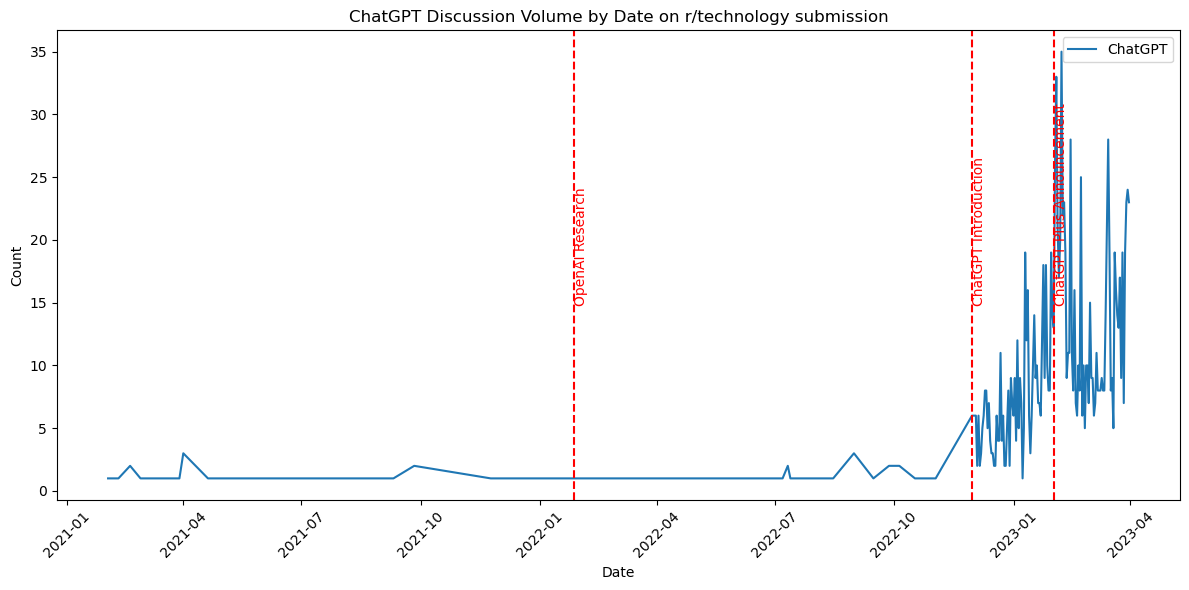

In [50]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert 'created_date' column to datetime
sub_top1['created_date'] = pd.to_datetime(sub_top1['created_date'])

# Sort the DataFrame by 'created_date' column
sub_top1 = sub_top1.sort_values(by='created_date')

plt.figure(figsize=(12, 6))
plt.rcParams["figure.dpi"] = 200

# Plot submissions
#plt.plot(tech_date_df1['created_date'], tech_date_df1['subs_count'], label='Submissions')


plt.plot(sub_top1['created_date'], sub_top1['chatgpt_count'], label='ChatGPT')

# Add vertical lines for significant events
plt.axvline(x=pd.to_datetime('2022-01-27'), color='red', linestyle='--')
plt.text(pd.to_datetime('2022-01-27'), 15, "OpenAI Research", color='red', rotation=90)

plt.axvline(x=pd.to_datetime('2022-11-30'), color='red', linestyle='--')
plt.text(pd.to_datetime('2022-11-30'), 15, "ChatGPT Introduction", color='red', rotation=90)

plt.axvline(x=pd.to_datetime('2023-02-01'), color='red', linestyle='--')
plt.text(pd.to_datetime('2023-02-01'), 15, "ChatGPT Plus Announcement", color='red', rotation=90)

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('ChatGPT Discussion Volume by Date on r/technology submission')
plt.legend()

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [51]:
# Define the list of keywords
keywords = [
    "chatgpt", "bard", "copilot", "deepmind", "waymo",
    "mobileye", "aurora", "oculus", "apple", "metaverse",
    "drone", "dog", "humanoid", "roomba"
]

# Calculate counts for each keyword
subset_counts1 = (
    cleaned_df_coms
    .agg(
        *(sum(col(f"contains_{keyword}").cast("integer")).alias(f"{keyword}_count") for keyword in keywords)
    )
)

In [ ]:
subset_counts1.show()

In [52]:
# `chatgpt` is the most common technical product discussed in comments

com_top = cleaned_df_coms.groupBy(['created_date','contains_chatgpt']).agg(count("created_date")\
                                                                         .alias("chatgpt_count")).sort(desc('created_date'))

In [ ]:
com_top1 = com_top.filter(com_top['contains_chatgpt'] == True)

com_top1.show()

In [ ]:
com_top1_df = com_top1.toPandas()

In [ ]:
com_top1_df.to_csv("date_keywords/Com_chatgpt.csv",index=False)

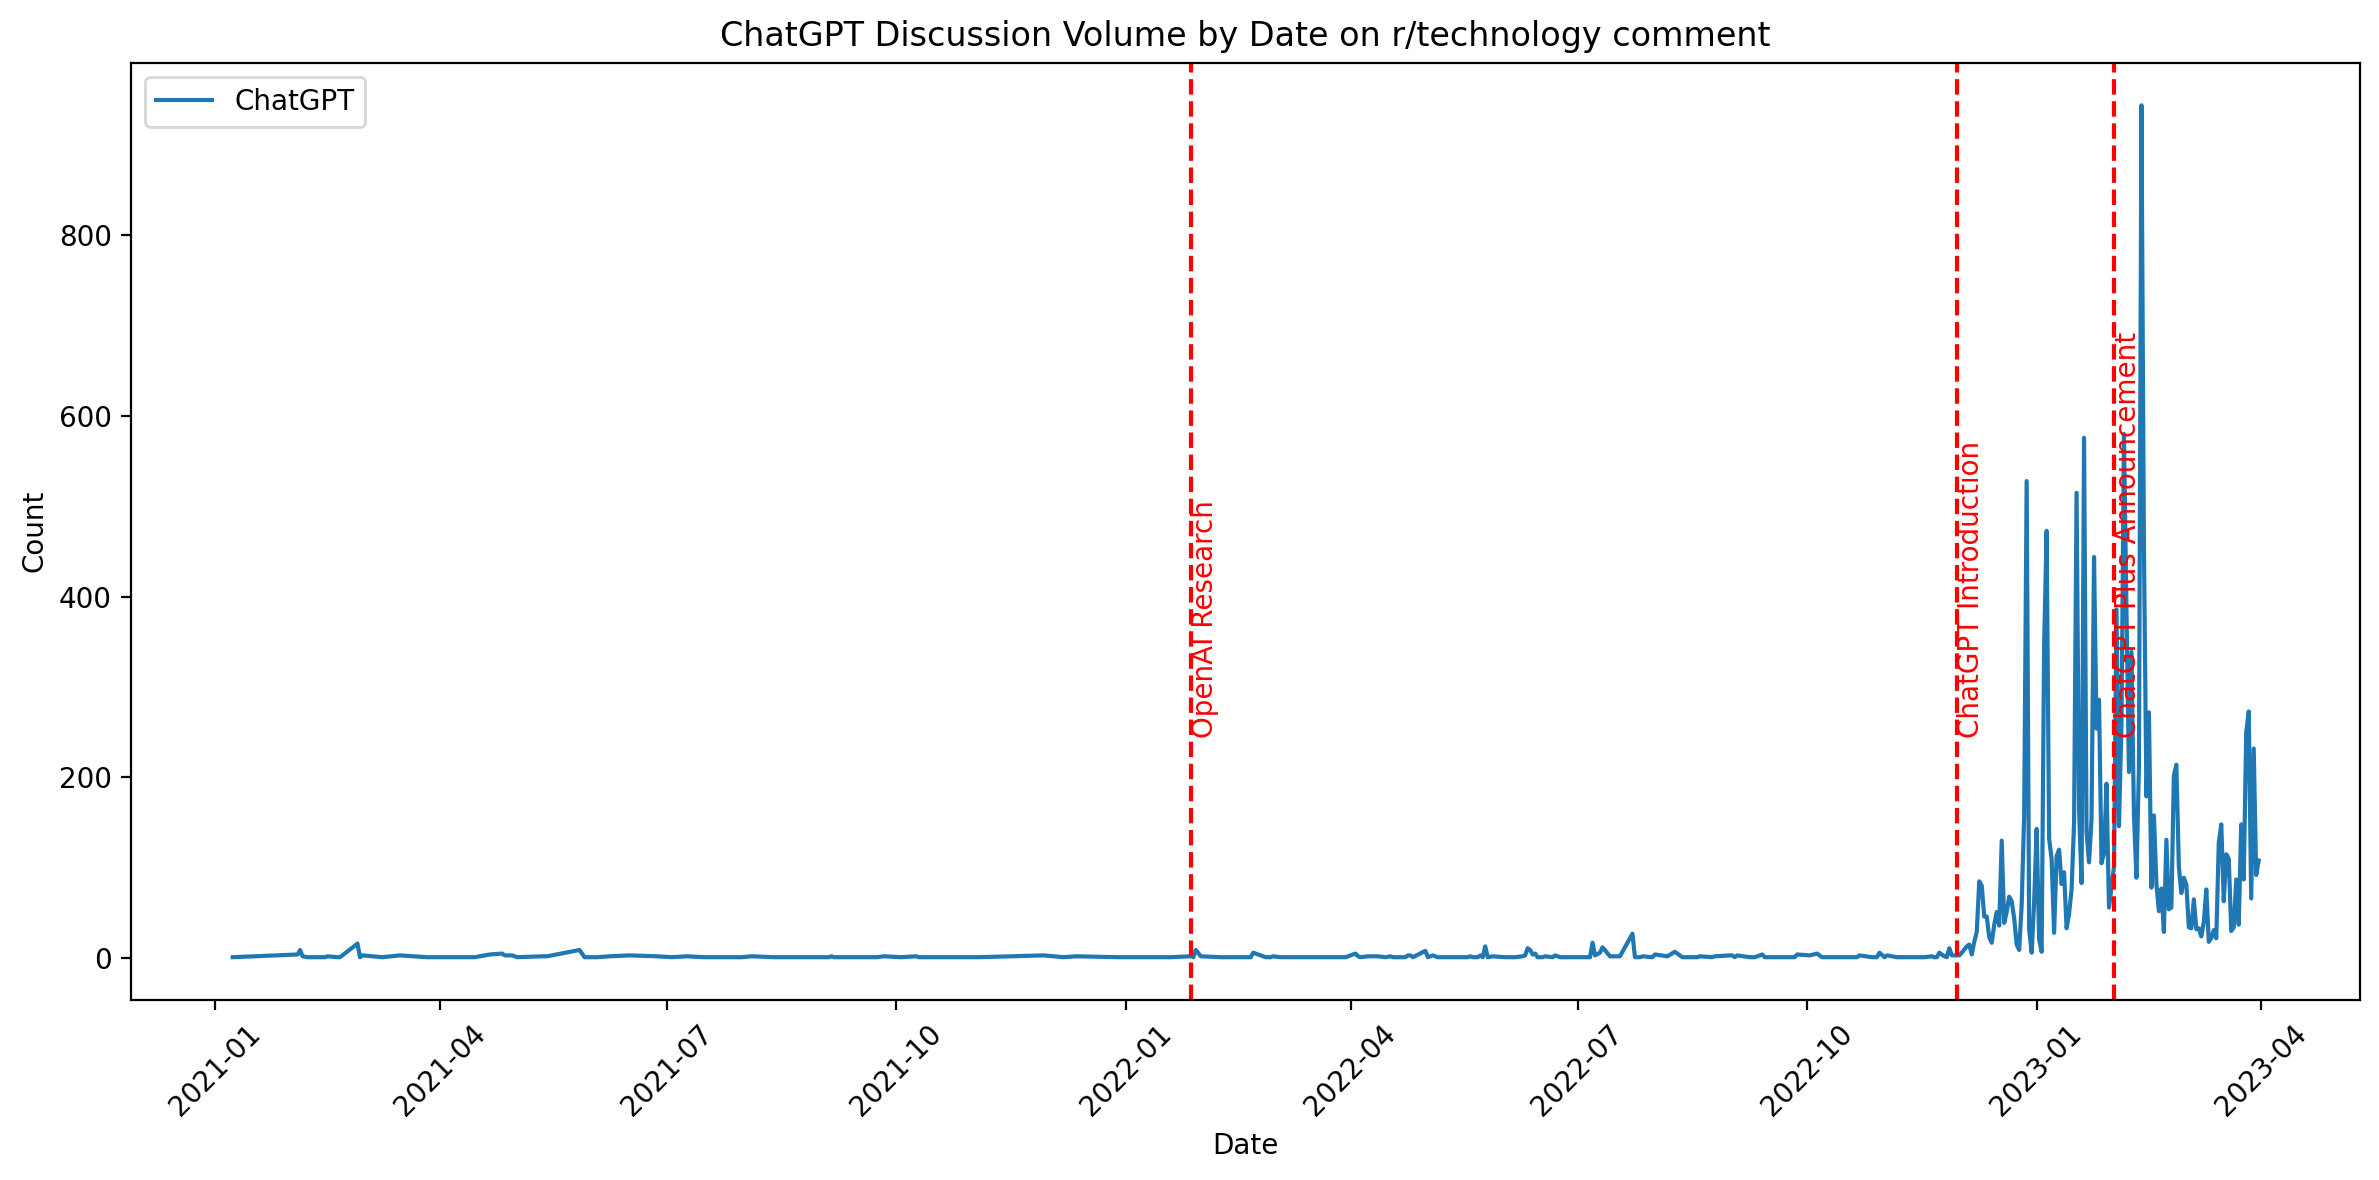

In [46]:
# Convert 'created_date' column to datetime
com_top1_df['created_date'] = pd.to_datetime(com_top1_df['created_date'])

# Sort the DataFrame by 'created_date' column
com_top1_df = com_top1_df.sort_values(by='created_date')

plt.figure(figsize=(12, 6))
plt.rcParams["figure.dpi"] = 200

# Plot submissions
#plt.plot(tech_date_df1['created_date'], tech_date_df1['subs_count'], label='Submissions')

# Plot comments
plt.plot(com_top1_df['created_date'], com_top1_df['chatgpt_count'], label='ChatGPT')

# Add vertical lines for significant events
plt.axvline(x=pd.to_datetime('2022-01-27'), color='red', linestyle='--')
plt.text(pd.to_datetime('2022-01-27'), 250, "OpenAI Research", color='red', rotation=90)

plt.axvline(x=pd.to_datetime('2022-11-30'), color='red', linestyle='--')
plt.text(pd.to_datetime('2022-11-30'), 250, "ChatGPT Introduction", color='red', rotation=90)

plt.axvline(x=pd.to_datetime('2023-02-01'), color='red', linestyle='--')
plt.text(pd.to_datetime('2023-02-01'), 250, "ChatGPT Plus Announcement", color='red', rotation=90)

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('ChatGPT Discussion Volume by Date on r/technology comment')
plt.legend()

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 7. Analyzing Mean Sentiment Scores of Technology Products Over Time


In this part, we start our examination by pinpointing an array of tech products to establish targeted classifications. Subsequently, we will sort each submission in the `r/Technology` subreddit by the date it was posted and the particular tech product it references. Our goal is to map out a comprehensive sentiment trend over time by computing the average sentiment rating for submissions grouped into each tech category. This method will give us an insight into the community's feelings and opinions regarding these products. It will also equip us to highlight products that are persistently viewed negatively, uncovering trends of discontent or particular issues. Through our analysis, we aim to provide a clear picture of the public's sentiment towards a variety of tech products.

Leveraging a ready-to-use sentiment analysis model from John Snow Labs' Spark NLP, we labeled each submission with a sentiment classification: positive, negative, or neutral. The chosen model, `analyze_sentimentdl_use_twitter`, was developed with training on a dataset from Twitter and employs Universal Sentence Encoder embeddings. We opted for this model over one trained on IMDB reviews, believing that a model honed on social media content aligns more closely with the language and style found in Reddit submissions and comments.

In [36]:
%%time
cleaned_df_coms = spark.read.parquet("filter_news_com.parquet", header=True)

CPU times: user 870 µs, sys: 3.04 ms, total: 3.91 ms
Wall time: 201 ms


In [37]:
# Use data: cleaned_df_subs
cleaned_df_coms.cache()

DataFrame[created_date: string, final_words: array<string>, final_sentence: string]

In [30]:
# Use data: cleaned_df_subs
cleaned_df_subs.cache()

DataFrame[adserver_click_url: string, adserver_imp_pixel: string, archived: boolean, author: string, author_cakeday: boolean, author_flair_css_class: string, author_flair_text: string, author_id: string, brand_safe: boolean, contest_mode: boolean, created_utc: timestamp, crosspost_parent: string, crosspost_parent_list: array<struct<approved_at_utc:string,approved_by:string,archived:boolean,author:string,author_flair_css_class:string,author_flair_text:string,banned_at_utc:string,banned_by:string,brand_safe:boolean,can_gild:boolean,can_mod_post:boolean,clicked:boolean,contest_mode:boolean,created:double,created_utc:double,distinguished:string,domain:string,downs:bigint,edited:boolean,gilded:bigint,hidden:boolean,hide_score:boolean,id:string,is_crosspostable:boolean,is_reddit_media_domain:boolean,is_self:boolean,is_video:boolean,likes:string,link_flair_css_class:string,link_flair_text:string,locked:boolean,media:string,mod_reports:array<string>,name:string,num_comments:bigint,num_crosspos

#### Build a Sentiment Model

In [10]:
MODEL_NAME='sentimentdl_use_twitter'

# Assemble document
document_assembler = DocumentAssembler() \
    .setInputCol("final_sentence") \
    .setOutputCol("document")
  
# Encode sentences
use = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")

# Get sentiment
sentimentdl = SentimentDLModel.pretrained(name=MODEL_NAME, lang="en")\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("sentiment")

# Build and run the pipeline
nlpPipeline = Pipeline(
    stages=[
        document_assembler,
        use,
        sentimentdl
    ])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[ | ]tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
Download done! Loading the resource.
[ — ]

2024-04-23 23:28:47.907975: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[ | ]

2024-04-23 23:28:52.769678: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 60236800 exceeds 10% of free system memory.
2024-04-23 23:28:52.819441: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 60236800 exceeds 10% of free system memory.
2024-04-23 23:28:52.872448: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 60236800 exceeds 10% of free system memory.
2024-04-23 23:28:52.947202: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 60236800 exceeds 10% of free system memory.
2024-04-23 23:28:53.010663: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 60236800 exceeds 10% of free system memory.


[ — ]

[OK!]
sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
[ | ]sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
[ / ]Download done! Loading the resource.
[OK!]


In [33]:
# Run the model
pipelineModel = nlpPipeline.fit(cleaned_df_subs)
results = pipelineModel.transform(cleaned_df_subs)

In [16]:
# Run the model
pipelineModel = nlpPipeline.fit(cleaned_df_coms)
results = pipelineModel.transform(cleaned_df_coms)

In [17]:
# Print the results schema
results.printSchema()

root
 |-- created_date: string (nullable = true)
 |-- final_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- final_sentence: string (nullable = true)
 |-- contains_chatgpt: boolean (nullable = true)
 |-- contains_bard: boolean (nullable = true)
 |-- contains_copilot: boolean (nullable = true)
 |-- contains_deepmind: boolean (nullable = true)
 |-- contains_waymo: boolean (nullable = true)
 |-- contains_mobileye: boolean (nullable = true)
 |-- contains_aurora: boolean (nullable = true)
 |-- contains_oculus: boolean (nullable = true)
 |-- contains_apple: boolean (nullable = true)
 |-- contains_metaverse: boolean (nullable = true)
 |-- contains_drone: boolean (nullable = true)
 |-- contains_dog: boolean (nullable = true)
 |-- contains_humanoid: boolean (nullable = true)
 |-- contains_roomba: boolean (nullable = true)
 |-- document: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true

Pull out the sentiment output into its own column in the main dataframe. Create a new dataframe that includes sentiment, created date, final sentence and our dummy variables: contains_chatgpt, contains_bard, contains_copilot, contains_deepmind, contains_waymo, contains_mobileye, contains_aurora, contains_oculus, contains_apple, contains_metaverse, contains_drone, contains_dog, contains_humanoid, contains_roomba

In [35]:
from pyspark.sql.functions import col

# Extract the sentiment result
extracted_sentiment = results.withColumn('sentiment', col('sentiment.result').getItem(0))

# Selecting the necessary columns for the new DataFrame
new_df = extracted_sentiment.select(
    "contains_chatgpt", "contains_bard", "contains_copilot", 
    "contains_deepmind", "contains_waymo", "contains_mobileye",
    "contains_aurora", "contains_oculus", "contains_apple", 
    "contains_metaverse", "contains_drone", "contains_dog", 
    "contains_humanoid", "contains_roomba", 'created_date', 'final_sentence', 'sentiment'
)

# Display the DataFrame
new_df.show()

+----------------+-------------+----------------+-----------------+--------------+-----------------+---------------+---------------+--------------+------------------+--------------+------------+-----------------+---------------+------------+--------------------+---------+
|contains_chatgpt|contains_bard|contains_copilot|contains_deepmind|contains_waymo|contains_mobileye|contains_aurora|contains_oculus|contains_apple|contains_metaverse|contains_drone|contains_dog|contains_humanoid|contains_roomba|created_date|      final_sentence|sentiment|
+----------------+-------------+----------------+-----------------+--------------+-----------------+---------------+---------------+--------------+------------------+--------------+------------+-----------------+---------------+------------+--------------------+---------+
|           false|        false|           false|            false|         false|            false|          false|          false|         false|             false|         false|

In [18]:
from pyspark.sql.functions import col

# Extract the sentiment result
extracted_sentiment = results.withColumn('sentiment', col('sentiment.result').getItem(0))

# Selecting the necessary columns for the new DataFrame
new_df = extracted_sentiment.select(
    "contains_chatgpt", "contains_bard", "contains_copilot", 
    "contains_deepmind", "contains_waymo", "contains_mobileye",
    "contains_aurora", "contains_oculus", "contains_apple", 
    "contains_metaverse", "contains_drone", "contains_dog", 
    "contains_humanoid", "contains_roomba", 'created_date', 'final_sentence', 'sentiment'
)

In [19]:
# Create a new foler to save sentiment score files
!mkdir -p ./product_sentiment_score_com

In [20]:
from pyspark.sql.functions import col, when, avg

# Convert sentiment to a numeric value
new_df = new_df.withColumn('sentiment_score', 
                   when(col('sentiment') == 'positive', 1)
                   .when(col('sentiment') == 'neutral', 0)
                   .when(col('sentiment') == 'negative', -1))

# Calculate the mean sentiment score for chatgpt
chatgpt_mean_sentiment = (new_df
                         .filter(col("contains_chatgpt"))
                         .groupBy('created_date')
                         .agg(avg('sentiment_score').alias('chatgpt_mean_sentiment_score'))
                         .orderBy('created_date'))
                
chatgpt_mean_sentiment.toPandas().to_csv("product_sentiment_score_com/contains_chatgpt_mean_sentiment.csv",index=False)


24/04/23 23:31:58 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [22]:
# Do the same thing for the other technical products

from pyspark.sql.functions import col, avg

# Assuming `new_df` is your PySpark DataFrame
product_list = [
    'contains_bard', 'contains_copilot', 'contains_deepmind', 'contains_waymo',
    'contains_mobileye', 'contains_aurora', 'contains_oculus', 'contains_apple',
    'contains_metaverse', 'contains_drone', 'contains_dog', 'contains_humanoid',
    'contains_roomba'
]

for product in product_list:
    mean_sentiment = (new_df
                      .filter(col(product))
                      .groupBy('created_date')
                      .agg(avg('sentiment_score').alias(product + '_mean_sentiment'))
                      .orderBy('created_date'))

    # Converting Spark DataFrame to Pandas DataFrame
    mean_sentiment_pd = mean_sentiment.toPandas()

    # Saving to CSV
    mean_sentiment_pd.to_csv("product_sentiment_score_com/{}_mean_sentiment.csv".format(product), index=False)

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:458)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:551)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:519)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# List of product names
# We get 0 sample of sentiment score for: apple, dog, and humanoid
products = [
    'chatgpt', 'aurora', 'bard', 'copilot', 
    'deepmind', 'drone', 'metaverse', 'mobileye', 'roomba',
    'oculus', 'waymo'
]

# Initialize an empty DataFrame to hold the combined data
combined_df = pd.DataFrame()

for product in products:
    # Read the CSV into a DataFrame
    temp_df = pd.read_csv(f"product_sentiment_score_com/contains_{product}_mean_sentiment.csv")
    
    # Make sure the 'created_date' column is datetime type for merging and plotting
    temp_df['created_date'] = pd.to_datetime(temp_df['created_date'])
    
    # Rename the sentiment column to the product's name for clarity after merge
    temp_df.rename(columns={temp_df.columns[1]: f"{product}_sentiment"}, inplace=True)
    
    if combined_df.empty:
        combined_df = temp_df
    else:
        # Merge the temporary DataFrame into the combined DataFrame on the 'created_date' column
        combined_df = pd.merge(combined_df, temp_df, on='created_date', how='outer')

# Ensure the combined DataFrame is sorted by date
combined_df.sort_values('created_date', inplace=True)


In [24]:
combined_df1 = combined_df.copy()
combined_df1 = combined_df1.fillna(0)
# List of sentiment score columns
sentiment_columns = [
    'chatgpt_sentiment', 'aurora_sentiment', 'bard_sentiment', 'copilot_sentiment',
    'deepmind_sentiment', 'drone_sentiment', 'metaverse_sentiment', 'mobileye_sentiment',
    'roomba_sentiment', 'oculus_sentiment', 'waymo_sentiment'
]

# Calculate the mean of the sentiment columns and create a new column 'mean'
combined_df1['mean_sentiment'] = combined_df1[sentiment_columns].mean(axis=1)

# Display the DataFrame to verify the new column
combined_df1.head()

,created_date,chatgpt_sentiment,aurora_sentiment,bard_sentiment,copilot_sentiment,deepmind_sentiment,drone_sentiment,metaverse_sentiment,mobileye_sentiment,roomba_sentiment,oculus_sentiment,waymo_sentiment,mean_sentiment
0,2021-01-01,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,1.0,0.181818
1,2021-01-02,0.0,0.0,0.0,0.0,0.0,0.833333,0.0,0.0,0.0,1.0,1.0,0.257576
2,2021-01-03,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.5,0.045455
3,2021-01-04,0.0,0.0,0.0,0.0,1.0,0.145161,0.0,0.0,0.0,0.0,1.0,0.195015
4,2021-01-05,0.0,0.0,0.0,0.0,0.0,-0.062500,0.0,0.0,1.0,0.0,1.0,0.176136


In [25]:
combined_df1.to_csv("tech_sentiment_daily_com.csv",index=False)

In [26]:
# List of product names
products = [
    'chatgpt', 'aurora', 'bard', 'copilot', 
    'deepmind', 'drone', 'metaverse', 'mobileye', 'roomba',
    'oculus', 'waymo'
]

# Initialize an empty dictionary to hold the counts
record_counts = {}

for product in products:
    try:
        # Read the CSV into a DataFrame
        temp_df = pd.read_csv(f"product_sentiment_score_com/contains_{product}_mean_sentiment.csv")

        # Make sure the 'created_date' column is datetime type for merging and plotting
        temp_df['created_date'] = pd.to_datetime(temp_df['created_date'])

        # Store the count of records in the dictionary
        record_counts[product] = len(temp_df)
    except FileNotFoundError:
        record_counts[product] = 0

record_counts_df = pd.DataFrame(list(record_counts.items()), columns=['Product', 'Count'])
record_counts_df

,Product,Count
0,chatgpt,225
1,aurora,26
2,bard,99
3,copilot,206
4,deepmind,114
5,drone,796
6,metaverse,278
7,mobileye,49
8,roomba,210
9,oculus,562


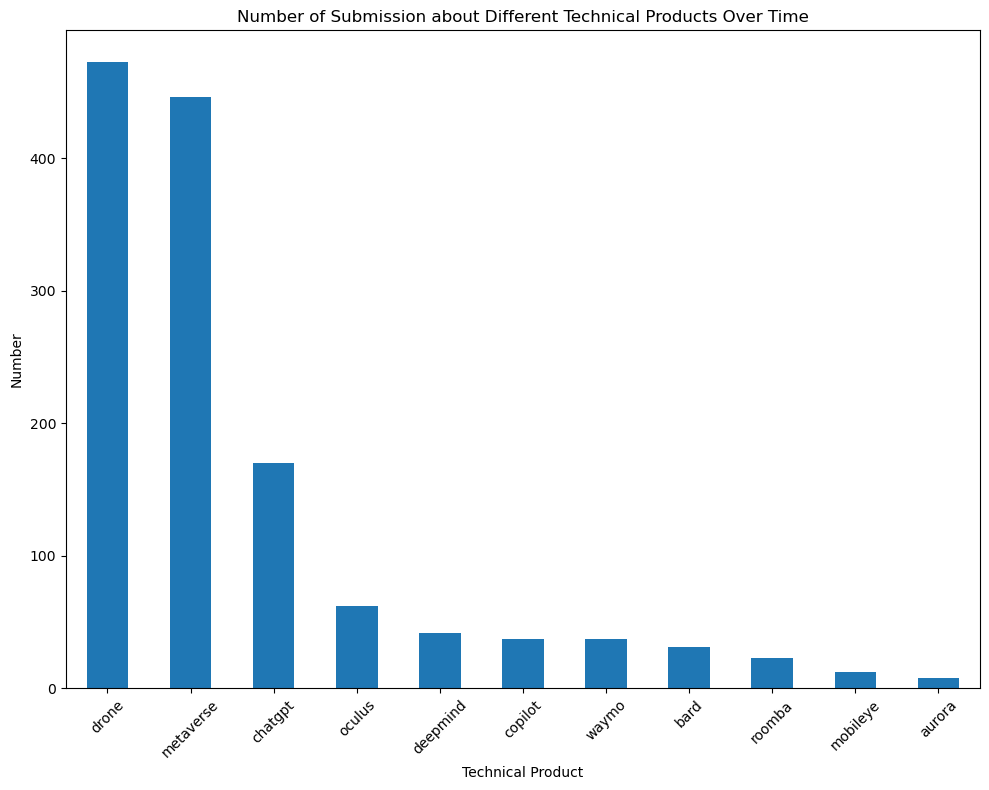

In [63]:
sorted_record_counts_df = record_counts_df.sort_values(by='Count',ascending=False)

# Create a bar plot 
#sorted_record_counts_df.plot(kind='bar', figsize=(10, 8))
# Create a bar plot using 'Product' as the x-axis
sorted_record_counts_df.plot(kind='bar', x='Product', y='Count', figsize=(10, 8), legend=False)


plt.title('Number of Submission about Different Technical Products Over Time')
plt.xlabel('Technical Product')
plt.ylabel('Number')

plt.xticks(rotation=45)
plt.tight_layout()  

plt.show()

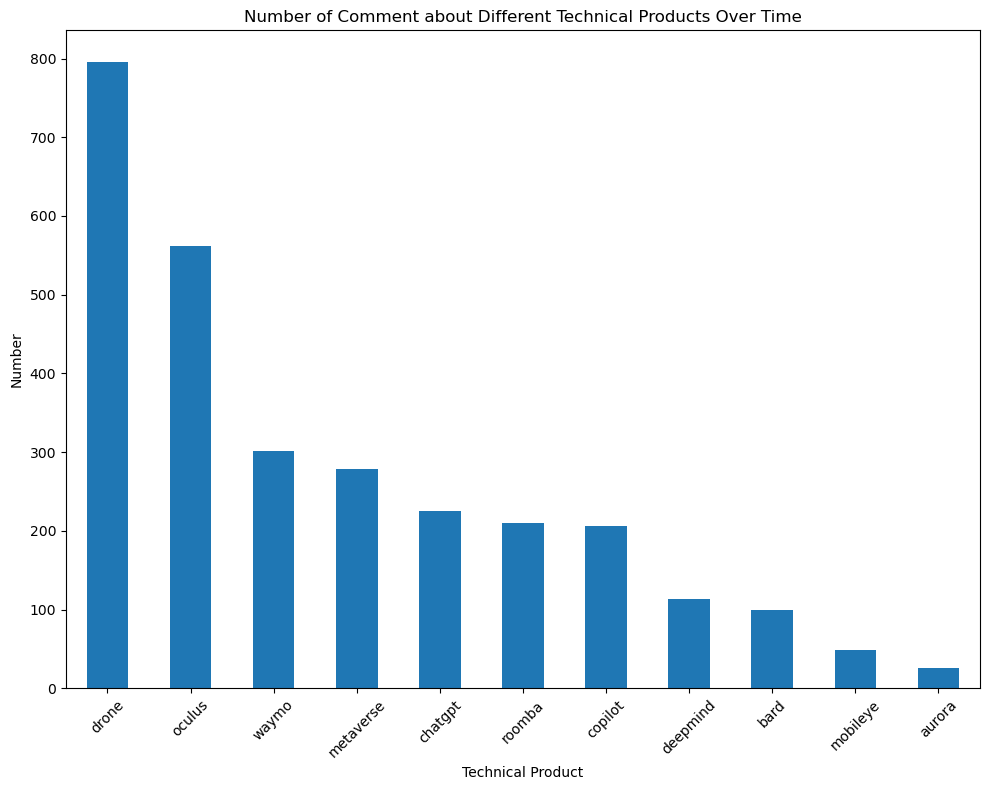

In [27]:
sorted_record_counts_df = record_counts_df.sort_values(by='Count',ascending=False)

# Create a bar plot 
#sorted_record_counts_df.plot(kind='bar', figsize=(10, 8))
# Create a bar plot using 'Product' as the x-axis
sorted_record_counts_df.plot(kind='bar', x='Product', y='Count', figsize=(10, 8), legend=False)


plt.title('Number of Comment about Different Technical Products Over Time')
plt.xlabel('Technical Product')
plt.ylabel('Number')

plt.xticks(rotation=45)
plt.tight_layout()  

plt.show()

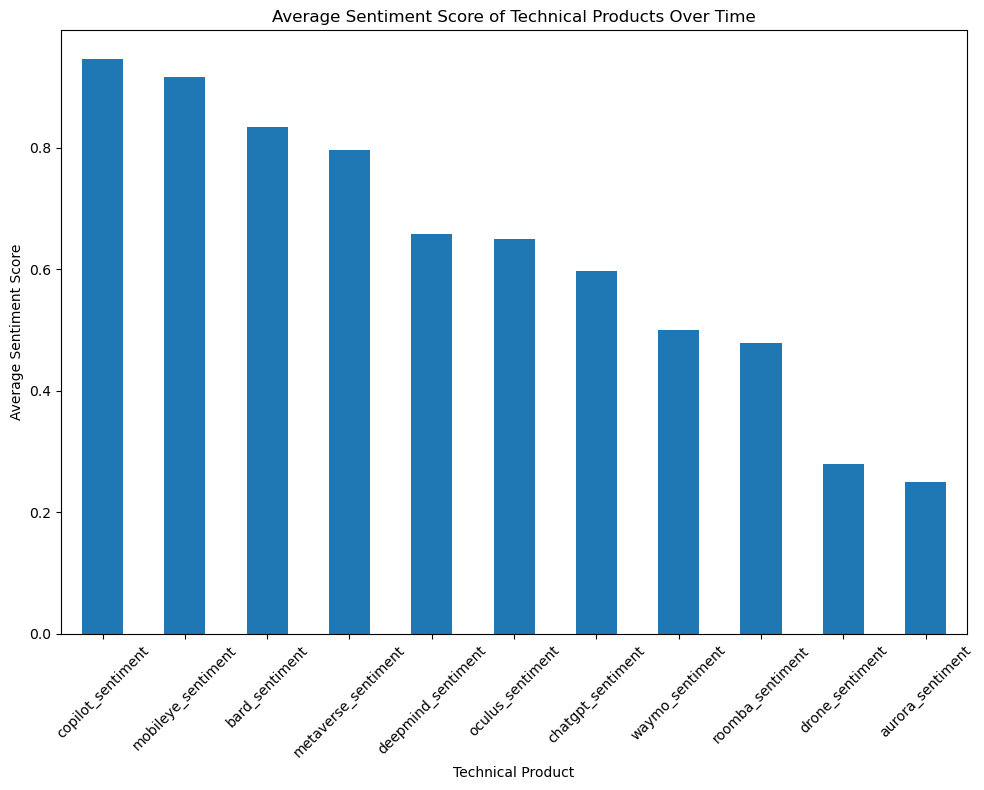

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'created_date' is index
#combined_df['created_date'] = pd.to_datetime(combined_df['created_date'])
#combined_df.set_index('created_date', inplace=True)

# Calculate the average sentiment score for every product
average_sentiments = combined_df.mean(axis=0, skipna=True)
sorted_average_sentiments = average_sentiments.sort_values(ascending=False)

# Create a bar plot 
sorted_average_sentiments.plot(kind='bar', figsize=(10, 8))

plt.title('Average Sentiment Score of Technical Products Over Time')
plt.xlabel('Technical Product')
plt.ylabel('Average Sentiment Score')

plt.xticks(rotation=45)
plt.tight_layout()  

plt.show()


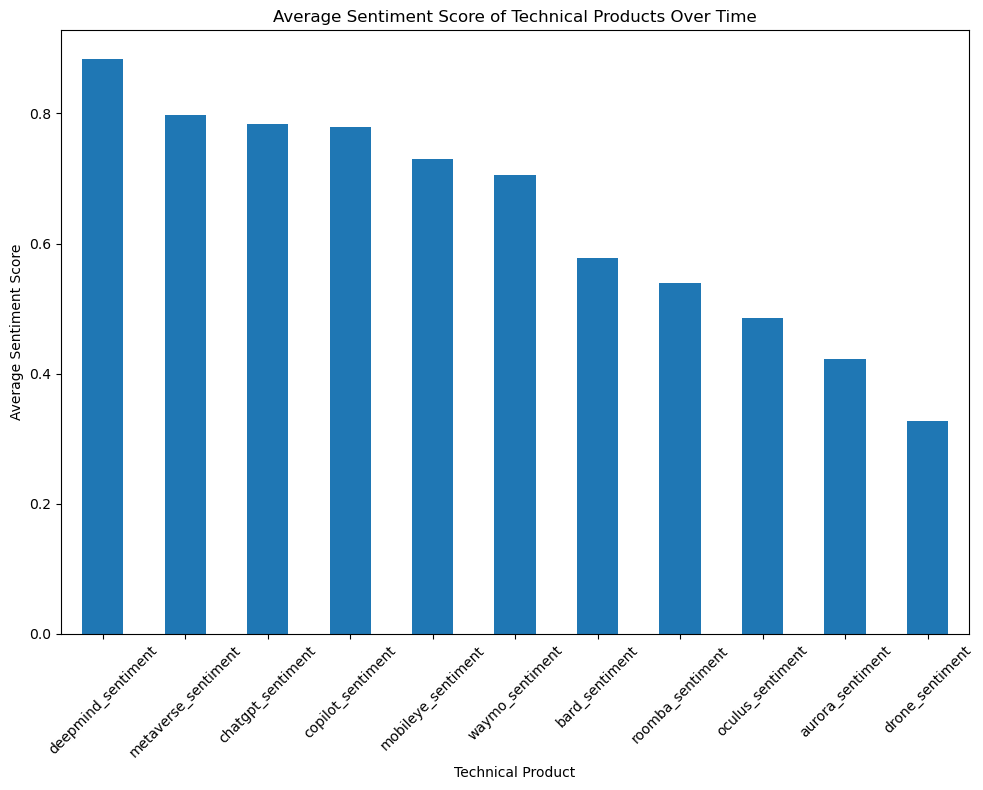

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'created_date' is index
#combined_df['created_date'] = pd.to_datetime(combined_df['created_date'])
#combined_df.set_index('created_date', inplace=True)

# Calculate the average sentiment score for every product
average_sentiments = combined_df.mean(axis=0, skipna=True)
sorted_average_sentiments = average_sentiments[1:].sort_values(ascending=False)

# Create a bar plot 
sorted_average_sentiments.plot(kind='bar', figsize=(10, 8))

plt.title('Average Sentiment Score of Technical Products Over Time')
plt.xlabel('Technical Product')
plt.ylabel('Average Sentiment Score')

plt.xticks(rotation=45)
plt.tight_layout()  

plt.show()

Next, we examine how the sentiment scores of three technical products(Chatgpt, Bard, Copilot) which have been most discussed, changed over time.

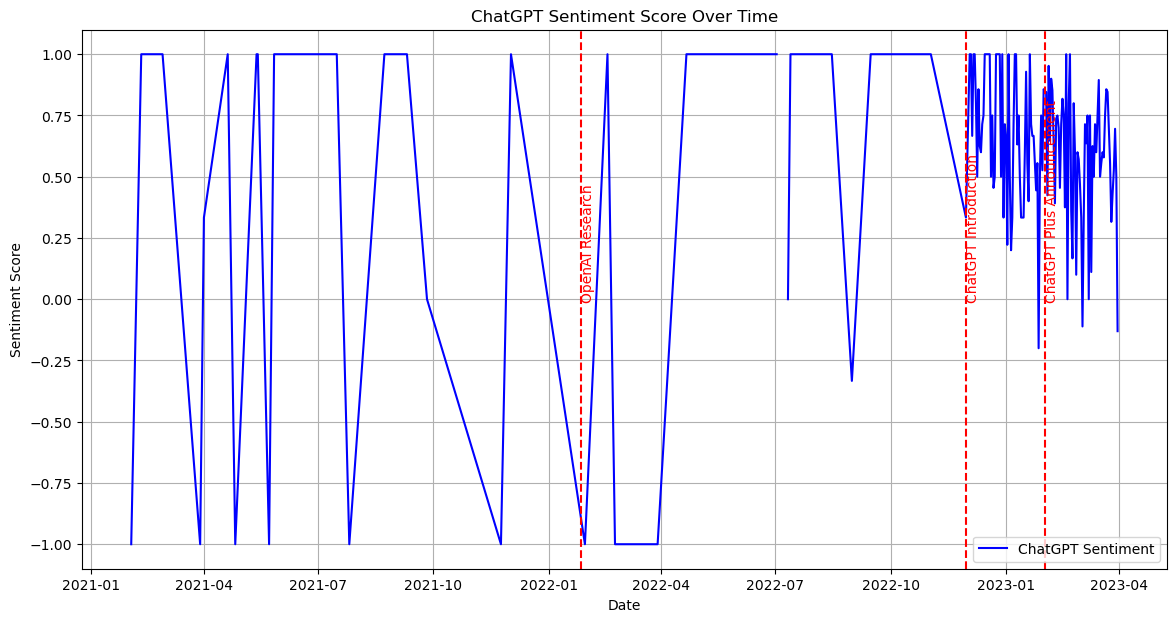

In [46]:
# Get the plot of sentiment score for chatgpt
contains_chatgpt_mean_sentiment=pd.read_csv("product_sentiment_score/contains_chatgpt_mean_sentiment.csv")

contains_chatgpt_mean_sentiment['created_date']=pd.to_datetime(contains_chatgpt_mean_sentiment['created_date'])
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(contains_chatgpt_mean_sentiment['created_date'], contains_chatgpt_mean_sentiment['chatgpt_mean_sentiment_score'], label='ChatGPT Sentiment', color='blue')
# Add vertical lines for significant events
plt.axvline(x=pd.to_datetime('2022-01-27'), color='red', linestyle='--')
plt.text(pd.to_datetime('2022-01-27'), 0, "OpenAI Research", color='red', rotation=90)

plt.axvline(x=pd.to_datetime('2022-11-30'), color='red', linestyle='--')
plt.text(pd.to_datetime('2022-11-30'), 0, "ChatGPT Introduction", color='red', rotation=90)

plt.axvline(x=pd.to_datetime('2023-02-01'), color='red', linestyle='--')
plt.text(pd.to_datetime('2023-02-01'), 0, "ChatGPT Plus Announcement", color='red', rotation=90)

plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('ChatGPT Sentiment Score Over Time')
plt.legend()
plt.grid(True)
plt.show()

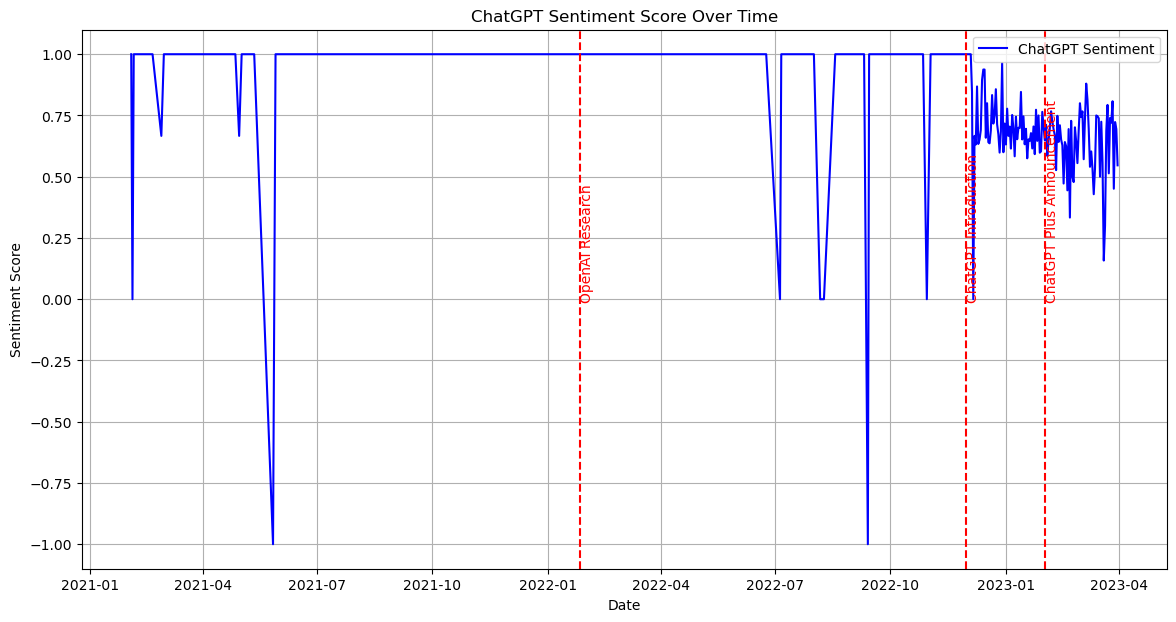

In [33]:
# Get the plot of sentiment score for chatgpt
contains_chatgpt_mean_sentiment=pd.read_csv("product_sentiment_score_com/contains_chatgpt_mean_sentiment.csv")

contains_chatgpt_mean_sentiment['created_date']=pd.to_datetime(contains_chatgpt_mean_sentiment['created_date'])
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(contains_chatgpt_mean_sentiment['created_date'], contains_chatgpt_mean_sentiment['chatgpt_mean_sentiment_score'], label='ChatGPT Sentiment', color='blue')
# Add vertical lines for significant events
plt.axvline(x=pd.to_datetime('2022-01-27'), color='red', linestyle='--')
plt.text(pd.to_datetime('2022-01-27'), 0, "OpenAI Research", color='red', rotation=90)

plt.axvline(x=pd.to_datetime('2022-11-30'), color='red', linestyle='--')
plt.text(pd.to_datetime('2022-11-30'), 0, "ChatGPT Introduction", color='red', rotation=90)

plt.axvline(x=pd.to_datetime('2023-02-01'), color='red', linestyle='--')
plt.text(pd.to_datetime('2023-02-01'), 0, "ChatGPT Plus Announcement", color='red', rotation=90)

plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('ChatGPT Sentiment Score Over Time')
plt.legend()
plt.grid(True)
plt.show()

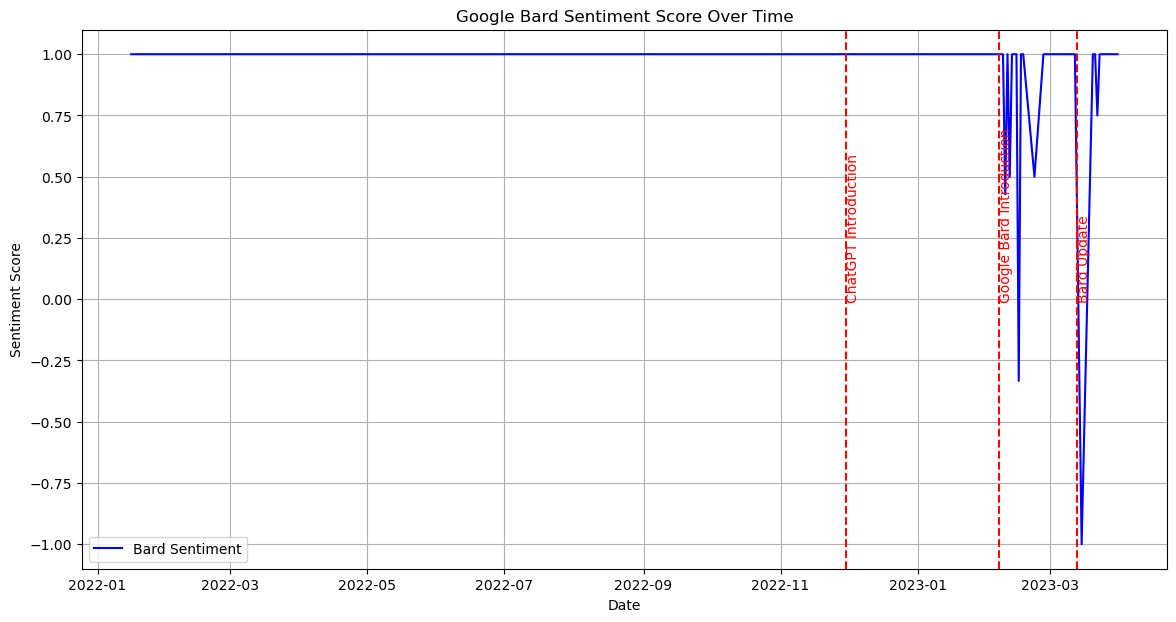

In [50]:
# Get the plot of sentiment score for bard
contains_bard_mean_sentiment=pd.read_csv("product_sentiment_score/contains_bard_mean_sentiment.csv")

contains_bard_mean_sentiment['created_date']=pd.to_datetime(contains_bard_mean_sentiment['created_date'])
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(contains_bard_mean_sentiment['created_date'], contains_bard_mean_sentiment['contains_bard_mean_sentiment'], label='Bard Sentiment', color='blue')
# Add vertical lines for significant events

plt.axvline(x=pd.to_datetime('2022-11-30'), color='red', linestyle='--')
plt.text(pd.to_datetime('2022-11-30'), 0, "ChatGPT Introduction", color='red', rotation=90)

plt.axvline(x=pd.to_datetime('2023-02-06'), color='red', linestyle='--')
plt.text(pd.to_datetime('2023-02-06'), 0, "Google Bard Introduction", color='red', rotation=90)

plt.axvline(x=pd.to_datetime('2023-03-13'), color='red', linestyle='--')
plt.text(pd.to_datetime('2023-03-13'), 0, "Bard Update", color='red', rotation=90)

plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Google Bard Sentiment Score Over Time')
plt.legend()
plt.grid(True)
plt.show()

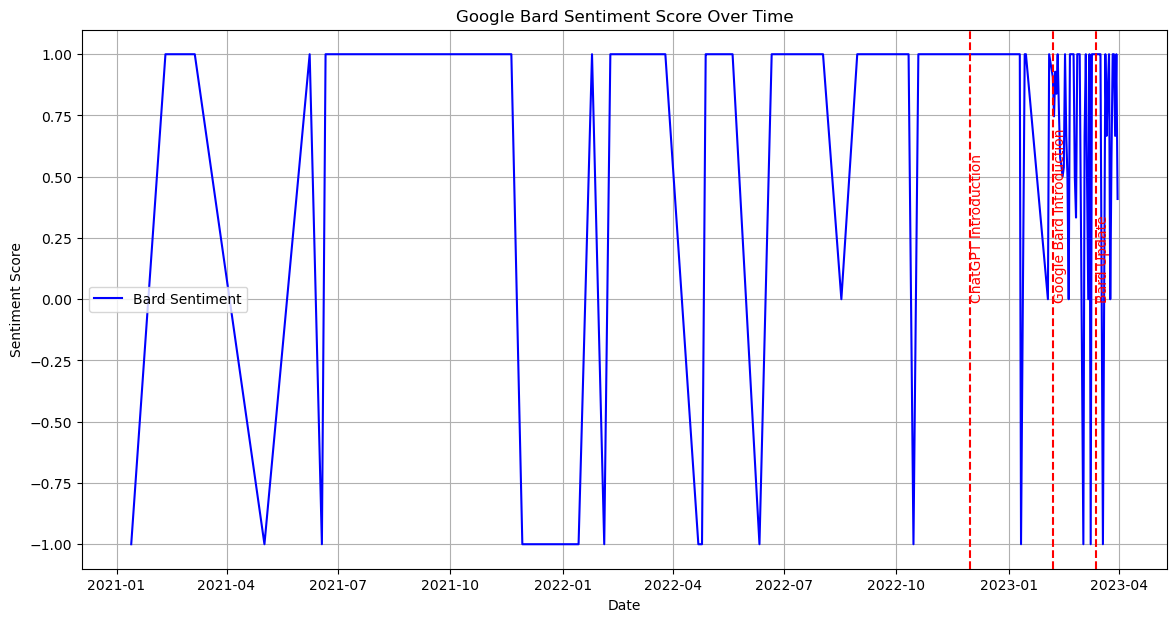

In [34]:
# Get the plot of sentiment score for bard
contains_bard_mean_sentiment=pd.read_csv("product_sentiment_score_com/contains_bard_mean_sentiment.csv")

contains_bard_mean_sentiment['created_date']=pd.to_datetime(contains_bard_mean_sentiment['created_date'])
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(contains_bard_mean_sentiment['created_date'], contains_bard_mean_sentiment['contains_bard_mean_sentiment'], label='Bard Sentiment', color='blue')
# Add vertical lines for significant events

plt.axvline(x=pd.to_datetime('2022-11-30'), color='red', linestyle='--')
plt.text(pd.to_datetime('2022-11-30'), 0, "ChatGPT Introduction", color='red', rotation=90)

plt.axvline(x=pd.to_datetime('2023-02-06'), color='red', linestyle='--')
plt.text(pd.to_datetime('2023-02-06'), 0, "Google Bard Introduction", color='red', rotation=90)

plt.axvline(x=pd.to_datetime('2023-03-13'), color='red', linestyle='--')
plt.text(pd.to_datetime('2023-03-13'), 0, "Bard Update", color='red', rotation=90)

plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Google Bard Sentiment Score Over Time')
plt.legend()
plt.grid(True)
plt.show()

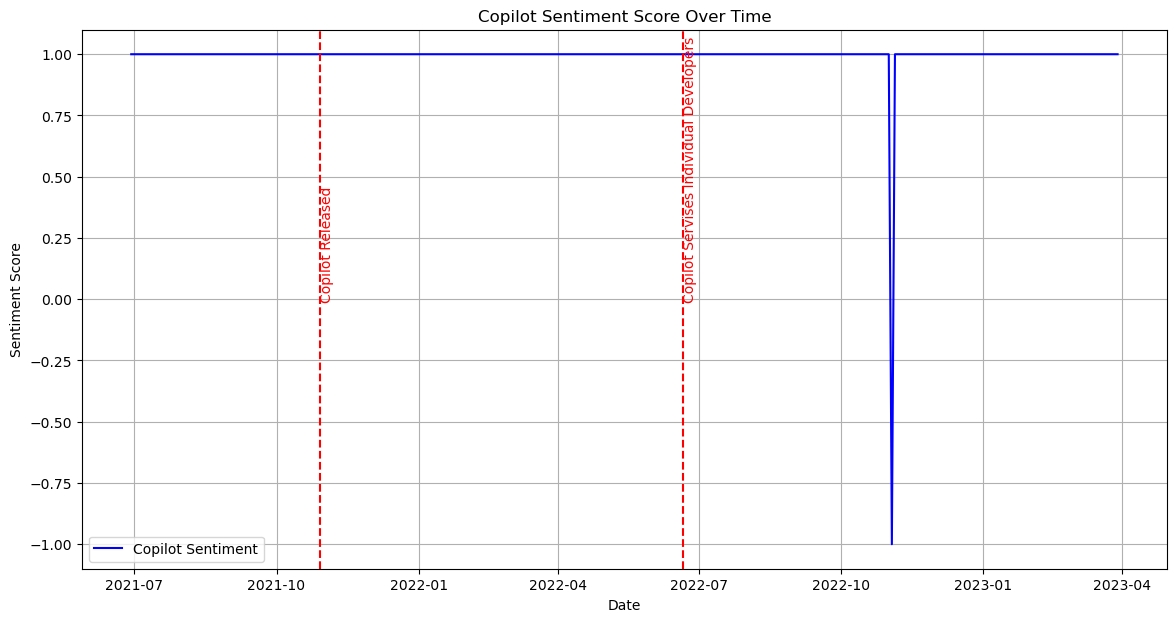

In [55]:
# Get the plot of sentiment score for copilot
contains_copilot_mean_sentiment=pd.read_csv("product_sentiment_score/contains_copilot_mean_sentiment.csv")

contains_copilot_mean_sentiment['created_date']=pd.to_datetime(contains_copilot_mean_sentiment['created_date'])
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(contains_copilot_mean_sentiment['created_date'], contains_copilot_mean_sentiment['contains_copilot_mean_sentiment'], label='Copilot Sentiment', color='blue')
# Add vertical lines for significant events

plt.axvline(x=pd.to_datetime('2021-10-29'), color='red', linestyle='--')
plt.text(pd.to_datetime('2021-10-29'), 0, "Copilot Released", color='red', rotation=90)

plt.axvline(x=pd.to_datetime('2022-06-21'), color='red', linestyle='--')
plt.text(pd.to_datetime('2022-06-21'), 0, "Copilot Servises Individual Developers", color='red', rotation=90)


plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Copilot Sentiment Score Over Time')
plt.legend()
plt.grid(True)
plt.show()

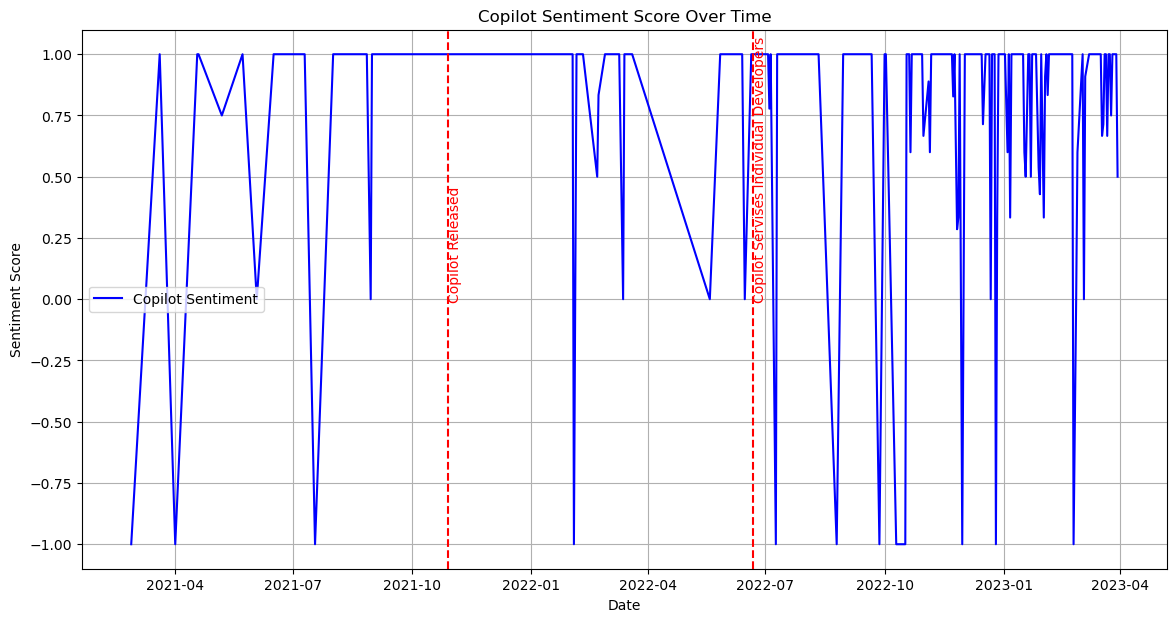

In [35]:
# Get the plot of sentiment score for copilot
contains_copilot_mean_sentiment=pd.read_csv("product_sentiment_score_com/contains_copilot_mean_sentiment.csv")

contains_copilot_mean_sentiment['created_date']=pd.to_datetime(contains_copilot_mean_sentiment['created_date'])
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(contains_copilot_mean_sentiment['created_date'], contains_copilot_mean_sentiment['contains_copilot_mean_sentiment'], label='Copilot Sentiment', color='blue')
# Add vertical lines for significant events

plt.axvline(x=pd.to_datetime('2021-10-29'), color='red', linestyle='--')
plt.text(pd.to_datetime('2021-10-29'), 0, "Copilot Released", color='red', rotation=90)

plt.axvline(x=pd.to_datetime('2022-06-21'), color='red', linestyle='--')
plt.text(pd.to_datetime('2022-06-21'), 0, "Copilot Servises Individual Developers", color='red', rotation=90)


plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Copilot Sentiment Score Over Time')
plt.legend()
plt.grid(True)
plt.show()

### 8. Tracking Sentiment Trends in Media-Driven (r/News) vs. Public-Driven (r/Technology) Tech Discussions

This study explores the differences in sentiment trends between the media-influenced `r/News` subreddit and the user-generated `r/Technology` subreddit. We calculate the average daily sentiment score for each subreddit within chosen technology categories, aiming to track changes in public and media attitudes toward these subjects over time. This method will offer a comparative view of how narratives about technology in both public and media spheres have developed and interacted over various periods.

In [21]:
# Use data: cleaned_df_subs
cleaned_df_subs.cache()

DataFrame[adserver_click_url: string, adserver_imp_pixel: string, archived: boolean, author: string, author_cakeday: boolean, author_flair_css_class: string, author_flair_text: string, author_id: string, brand_safe: boolean, contest_mode: boolean, created_utc: timestamp, crosspost_parent: string, crosspost_parent_list: array<struct<approved_at_utc:string,approved_by:string,archived:boolean,author:string,author_flair_css_class:string,author_flair_text:string,banned_at_utc:string,banned_by:string,brand_safe:boolean,can_gild:boolean,can_mod_post:boolean,clicked:boolean,contest_mode:boolean,created:double,created_utc:double,distinguished:string,domain:string,downs:bigint,edited:boolean,gilded:bigint,hidden:boolean,hide_score:boolean,id:string,is_crosspostable:boolean,is_reddit_media_domain:boolean,is_self:boolean,is_video:boolean,likes:string,link_flair_css_class:string,link_flair_text:string,locked:boolean,media:string,mod_reports:array<string>,name:string,num_comments:bigint,num_crosspos

#### Build a Sentiment Model

In [16]:
MODEL_NAME='sentimentdl_use_twitter'

# Assemble document
document_assembler = DocumentAssembler() \
    .setInputCol("final_sentence") \
    .setOutputCol("document")
  
# Encode sentences
use = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")

# Get sentiment
sentimentdl = SentimentDLModel.pretrained(name=MODEL_NAME, lang="en")\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("sentiment")

# Build and run the pipeline
nlpPipeline = Pipeline(
    stages=[
        document_assembler,
        use,
        sentimentdl
    ])


tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[ | ]tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
Download done! Loading the resource.
[ — ]

2024-04-23 03:35:36.646821: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[ | ]

2024-04-23 03:35:41.563324: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 60236800 exceeds 10% of free system memory.
2024-04-23 03:35:41.636729: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 60236800 exceeds 10% of free system memory.
2024-04-23 03:35:41.722665: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 60236800 exceeds 10% of free system memory.
2024-04-23 03:35:41.803413: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 60236800 exceeds 10% of free system memory.
2024-04-23 03:35:41.855492: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 60236800 exceeds 10% of free system memory.


[OK!]
sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
[ | ]sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
Download done! Loading the resource.
[OK!]


In [22]:
# Run the model
pipelineModel = nlpPipeline.fit(cleaned_df_subs)
results = pipelineModel.transform(cleaned_df_subs)

In [39]:
# Run the model
pipelineModel = nlpPipeline.fit(cleaned_df_coms)
results = pipelineModel.transform(cleaned_df_coms)

Pull out the sentiment output into its own column in the main dataframe. Create a new dataframe that includes sentiment, created date, final sentence and our dummy variables: contains_chatgpt, contains_bard, contains_copilot, contains_deepmind, contains_waymo, contains_mobileye, contains_aurora, contains_oculus, contains_apple, contains_metaverse, contains_drone, contains_dog, contains_humanoid, contains_roomba

In [40]:
from pyspark.sql.functions import col

# Extract the sentiment result
extracted_sentiment = results.withColumn('sentiment', col('sentiment.result').getItem(0))

# Selecting the necessary columns for the new DataFrame
new_df = extracted_sentiment.select(
    "contains_chatgpt", "contains_bard", "contains_copilot", 
    "contains_deepmind", "contains_waymo", "contains_mobileye",
    "contains_aurora", "contains_oculus", "contains_apple", 
    "contains_metaverse", "contains_drone", "contains_dog", 
    "contains_humanoid", "contains_roomba", 'created_date', 'final_sentence', 'sentiment'
)


In [23]:
from pyspark.sql.functions import col

# Extract the sentiment result
extracted_sentiment = results.withColumn('sentiment', col('sentiment.result').getItem(0))

# Selecting the necessary columns for the new DataFrame
new_df = extracted_sentiment.select(
    "contains_chatgpt", "contains_bard", "contains_copilot", 
    "contains_deepmind", "contains_waymo", "contains_mobileye",
    "contains_aurora", "contains_oculus", "contains_apple", 
    "contains_metaverse", "contains_drone", "contains_dog", 
    "contains_humanoid", "contains_roomba", 'created_date', 'final_sentence', 'sentiment'
)

# Display the DataFrame
new_df.show()

+----------------+-------------+----------------+-----------------+--------------+-----------------+---------------+---------------+--------------+------------------+--------------+------------+-----------------+---------------+------------+--------------------+---------+
|contains_chatgpt|contains_bard|contains_copilot|contains_deepmind|contains_waymo|contains_mobileye|contains_aurora|contains_oculus|contains_apple|contains_metaverse|contains_drone|contains_dog|contains_humanoid|contains_roomba|created_date|      final_sentence|sentiment|
+----------------+-------------+----------------+-----------------+--------------+-----------------+---------------+---------------+--------------+------------------+--------------+------------+-----------------+---------------+------------+--------------------+---------+
|           false|        false|           false|            false|         false|            false|          false|          false|         false|             false|         false|

In [41]:
# Create a new foler to save sentiment score files
!mkdir -p ./news_sentiment_score_com

In [42]:
from pyspark.sql.functions import col, when, avg

# Convert sentiment to a numeric value
new_df = new_df.withColumn('sentiment_score', 
                   when(col('sentiment') == 'positive', 1)
                   .when(col('sentiment') == 'neutral', 0)
                   .when(col('sentiment') == 'negative', -1))

# Calculate the mean sentiment score for chatgpt
chatgpt_mean_sentiment = (new_df
                         .filter(col("contains_chatgpt"))
                         .groupBy('created_date')
                         .agg(avg('sentiment_score').alias('chatgpt_mean_sentiment_score'))
                         .orderBy('created_date'))
                
chatgpt_mean_sentiment.toPandas().to_csv("news_sentiment_score_com/contains_chatgpt_mean_sentiment.csv",index=False)

In [43]:
# Do the same thing for the other technical products

from pyspark.sql.functions import col, avg

# Assuming `new_df` is your PySpark DataFrame
product_list = [
    'contains_bard', 'contains_copilot', 'contains_deepmind', 'contains_waymo',
    'contains_mobileye', 'contains_aurora', 'contains_oculus', 'contains_apple',
    'contains_metaverse', 'contains_drone', 'contains_dog', 'contains_humanoid',
    'contains_roomba'
]

for product in product_list:
    mean_sentiment = (new_df
                      .filter(col(product))
                      .groupBy('created_date')
                      .agg(avg('sentiment_score').alias(product + '_mean_sentiment'))
                      .orderBy('created_date'))

    # Converting Spark DataFrame to Pandas DataFrame
    mean_sentiment_pd = mean_sentiment.toPandas()

    # Saving to CSV
    mean_sentiment_pd.to_csv("news_sentiment_score_com/{}_mean_sentiment.csv".format(product), index=False)


In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# List of product names
# We get 0 sample of sentiment score for: apple, dog, and humanoid
products = [
    'chatgpt', 'aurora', 'bard', 'copilot', 
    'deepmind', 'drone', 'metaverse', 'mobileye', 'roomba',
    'oculus', 'waymo'
]

# Initialize an empty DataFrame to hold the combined data
combined_df = pd.DataFrame()

for product in products:
    # Read the CSV into a DataFrame
    temp_df = pd.read_csv(f"news_sentiment_score_com/contains_{product}_mean_sentiment.csv")
    
    # Make sure the 'created_date' column is datetime type for merging and plotting
    temp_df['created_date'] = pd.to_datetime(temp_df['created_date'])
    
    # Rename the sentiment column to the product's name for clarity after merge
    temp_df.rename(columns={temp_df.columns[1]: f"{product}_sentiment"}, inplace=True)
    
    if combined_df.empty:
        combined_df = temp_df
    else:
        # Merge the temporary DataFrame into the combined DataFrame on the 'created_date' column
        combined_df = pd.merge(combined_df, temp_df, on='created_date', how='outer')

# Ensure the combined DataFrame is sorted by date
combined_df.sort_values('created_date', inplace=True)

In [45]:
# List of product names
products = [
    'chatgpt', 'aurora', 'bard', 'copilot', 
    'deepmind', 'drone', 'metaverse', 'mobileye', 'roomba',
    'oculus', 'waymo'
]

# Initialize an empty dictionary to hold the counts
record_counts = {}

for product in products:
    try:
        # Read the CSV into a DataFrame
        temp_df = pd.read_csv(f"news_sentiment_score_com/contains_{product}_mean_sentiment.csv")

        # Make sure the 'created_date' column is datetime type for merging and plotting
        temp_df['created_date'] = pd.to_datetime(temp_df['created_date'])

        # Store the count of records in the dictionary
        record_counts[product] = len(temp_df)
    except FileNotFoundError:
        record_counts[product] = 0

record_counts_df = pd.DataFrame(list(record_counts.items()), columns=['Product', 'Count'])
record_counts_df

,Product,Count
0,chatgpt,126
1,aurora,129
2,bard,153
3,copilot,142
4,deepmind,12
5,drone,816
6,metaverse,36
7,mobileye,15
8,roomba,113
9,oculus,140


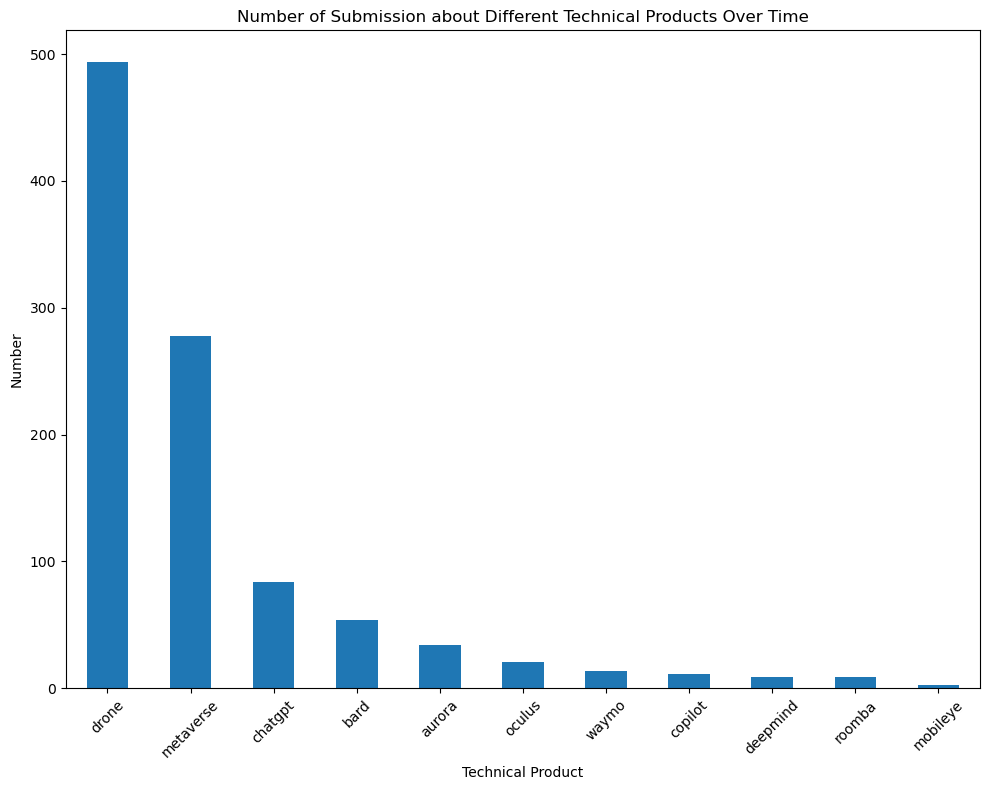

In [52]:
sorted_record_counts_df = record_counts_df.sort_values(by='Count',ascending=False)

# Create a bar plot 
#sorted_record_counts_df.plot(kind='bar', figsize=(10, 8))
# Create a bar plot using 'Product' as the x-axis
sorted_record_counts_df.plot(kind='bar', x='Product', y='Count', figsize=(10, 8), legend=False)


plt.title('Number of Submission about Different Technical Products Over Time')
plt.xlabel('Technical Product')
plt.ylabel('Number')

plt.xticks(rotation=45)
plt.tight_layout()  

plt.show()

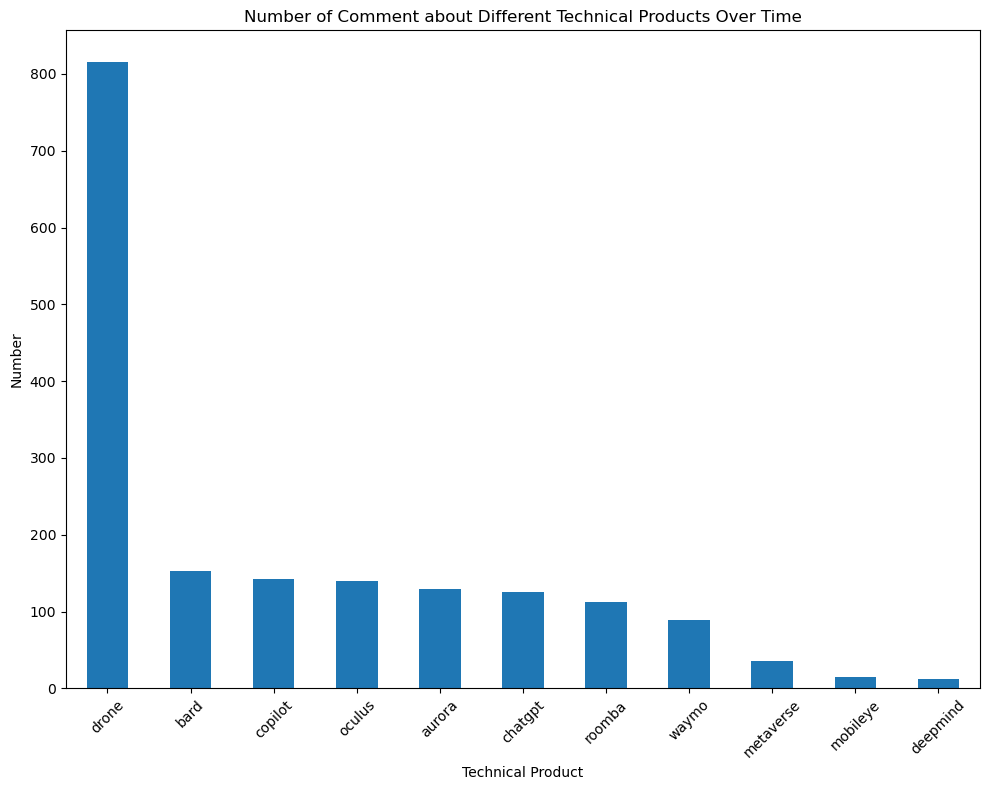

In [46]:
sorted_record_counts_df = record_counts_df.sort_values(by='Count',ascending=False)

# Create a bar plot 
#sorted_record_counts_df.plot(kind='bar', figsize=(10, 8))
# Create a bar plot using 'Product' as the x-axis
sorted_record_counts_df.plot(kind='bar', x='Product', y='Count', figsize=(10, 8), legend=False)


plt.title('Number of Comment about Different Technical Products Over Time')
plt.xlabel('Technical Product')
plt.ylabel('Number')

plt.xticks(rotation=45)
plt.tight_layout()  

plt.show()

In [55]:
combined_df.columns

Index(['created_date', 'chatgpt_sentiment', 'aurora_sentiment',
       'bard_sentiment', 'copilot_sentiment', 'deepmind_sentiment',
       'drone_sentiment', 'metaverse_sentiment', 'mobileye_sentiment',
       'roomba_sentiment', 'oculus_sentiment', 'waymo_sentiment'],
      dtype='object')

In [47]:
combined_df1 = combined_df.copy()
combined_df1 = combined_df1.fillna(0)
# List of sentiment score columns
sentiment_columns = [
    'chatgpt_sentiment', 'aurora_sentiment', 'bard_sentiment', 'copilot_sentiment',
    'deepmind_sentiment', 'drone_sentiment', 'metaverse_sentiment', 'mobileye_sentiment',
    'roomba_sentiment', 'oculus_sentiment', 'waymo_sentiment'
]

# Calculate the mean of the sentiment columns and create a new column 'mean'
combined_df1['mean_sentiment'] = combined_df1[sentiment_columns].mean(axis=1)

# Display the DataFrame to verify the new column
combined_df1.head()

,created_date,chatgpt_sentiment,aurora_sentiment,bard_sentiment,copilot_sentiment,deepmind_sentiment,drone_sentiment,metaverse_sentiment,mobileye_sentiment,roomba_sentiment,oculus_sentiment,waymo_sentiment,mean_sentiment
0,2021-01-01,0.0,0.0,0.0,0.0,0.0,0.416667,0.0,0.0,0.0,0.0,0.0,0.037879
1,2021-01-02,0.0,0.5,0.0,0.0,0.0,0.172414,0.0,0.0,0.0,0.0,0.0,0.061129
2,2021-01-03,0.0,-1.0,0.0,0.0,0.0,0.311475,0.0,0.0,0.0,0.0,0.0,-0.062593
3,2021-01-04,0.0,1.0,0.0,0.0,0.0,-0.333333,0.0,0.0,0.5,0.0,0.0,0.106061
4,2021-01-05,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,0.0,0.0,0.018182


In [48]:
combined_df1.to_csv("news_sentiment_daily_com.csv",index=False)

In [49]:
average_sentiments = combined_df.mean(axis=0, skipna=True).reset_index()[1:]
sorted_average_sentiments = average_sentiments.sort_values(by=0,ascending=False)
sorted_average_sentiments

,index,0
8,mobileye_sentiment,1.0
7,metaverse_sentiment,0.744444
11,waymo_sentiment,0.673131
5,deepmind_sentiment,0.666667
3,bard_sentiment,0.58642
1,chatgpt_sentiment,0.517576
9,roomba_sentiment,0.42621
10,oculus_sentiment,0.367466
4,copilot_sentiment,0.203449
6,drone_sentiment,-0.045901


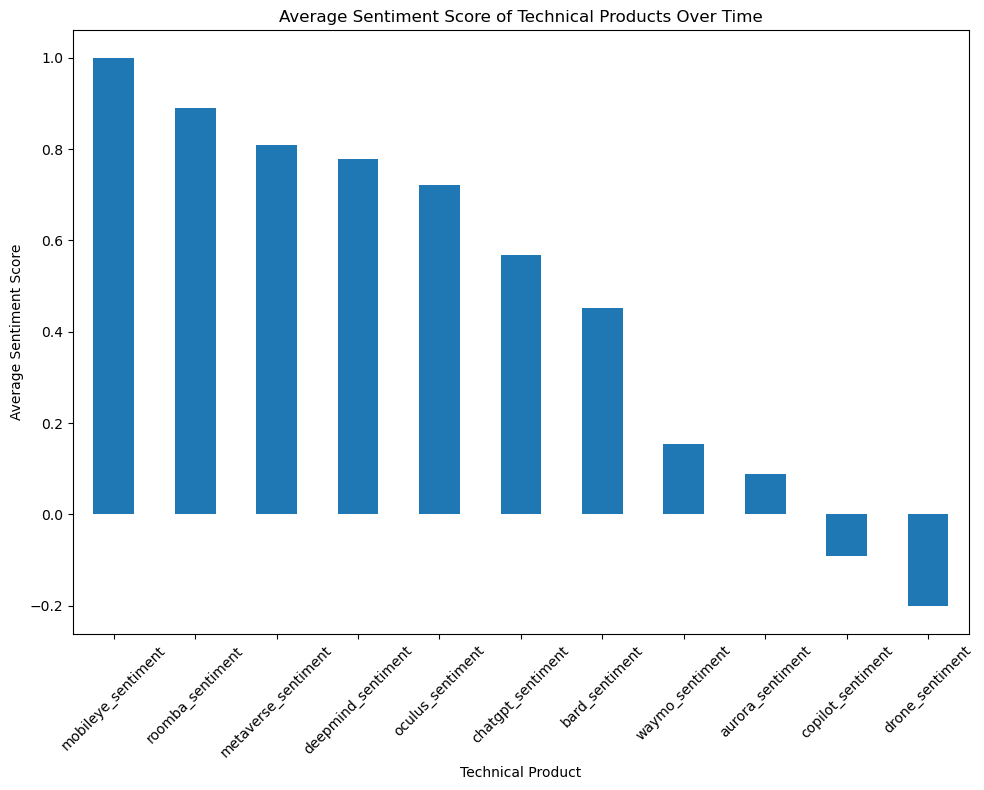

In [40]:
# Ensure 'created_date' is index
#combined_df['created_date'] = pd.to_datetime(combined_df['created_date'])
#combined_df.set_index('created_date', inplace=True)

# Calculate the average sentiment score for every product
average_sentiments = combined_df.mean(axis=0, skipna=True)[1:]
sorted_average_sentiments = average_sentiments.sort_values(ascending=False)

# Create a bar plot 
sorted_average_sentiments.plot(kind='bar', figsize=(10, 8))

plt.title('Average Sentiment Score of Technical Products Over Time')
plt.xlabel('Technical Product')
plt.ylabel('Average Sentiment Score')

plt.xticks(rotation=45)
plt.tight_layout()  

plt.show()

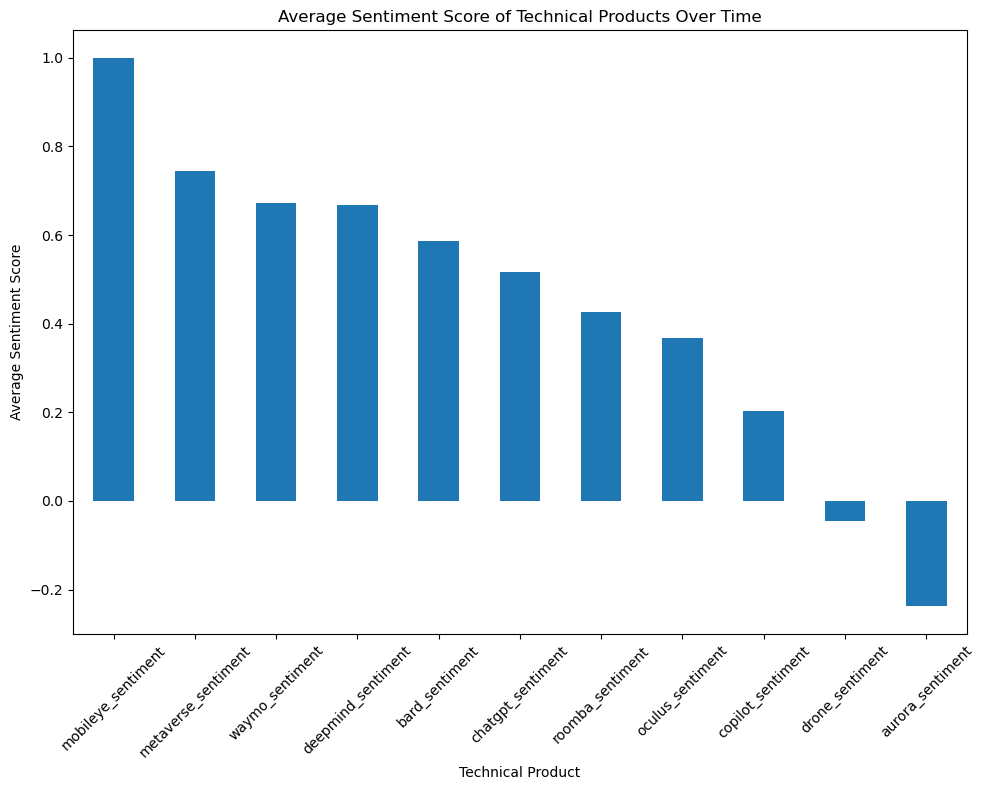

In [50]:
# Ensure 'created_date' is index
#combined_df['created_date'] = pd.to_datetime(combined_df['created_date'])
#combined_df.set_index('created_date', inplace=True)

# Calculate the average sentiment score for every product
average_sentiments = combined_df.mean(axis=0, skipna=True)[1:]
sorted_average_sentiments = average_sentiments.sort_values(ascending=False)

# Create a bar plot 
sorted_average_sentiments.plot(kind='bar', figsize=(10, 8))

plt.title('Average Sentiment Score of Technical Products Over Time')
plt.xlabel('Technical Product')
plt.ylabel('Average Sentiment Score')

plt.xticks(rotation=45)
plt.tight_layout()  

plt.show()

Next, we examine how the sentiment scores of three technical products(Chatgpt, Bard, Copilot) which have been most discussed, changed over time.

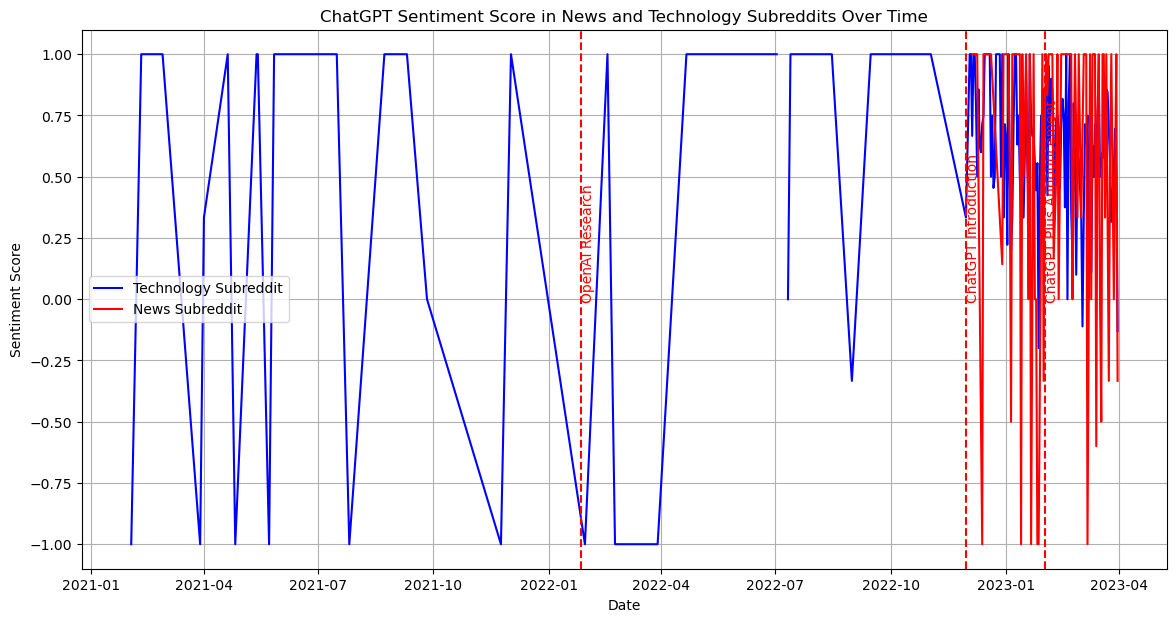

In [42]:
# Get the plot of sentiment score for chatgpt
contains_chatgpt_mean_sentiment=pd.read_csv("product_sentiment_score/contains_chatgpt_mean_sentiment.csv")
contains_chatgpt_mean_sentiment1=pd.read_csv("news_sentiment_score/contains_chatgpt_mean_sentiment.csv")

contains_chatgpt_mean_sentiment['created_date']=pd.to_datetime(contains_chatgpt_mean_sentiment['created_date'])
contains_chatgpt_mean_sentiment1['created_date']=pd.to_datetime(contains_chatgpt_mean_sentiment1['created_date'])
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(contains_chatgpt_mean_sentiment['created_date'], contains_chatgpt_mean_sentiment['chatgpt_mean_sentiment_score'], label='Technology Subreddit', color='blue')
plt.plot(contains_chatgpt_mean_sentiment1['created_date'], contains_chatgpt_mean_sentiment1['chatgpt_mean_sentiment_score'], label='News Subreddit', color='red')
# Add vertical lines for significant events
plt.axvline(x=pd.to_datetime('2022-01-27'), color='red', linestyle='--')
plt.text(pd.to_datetime('2022-01-27'), 0, "OpenAI Research", color='red', rotation=90)

plt.axvline(x=pd.to_datetime('2022-11-30'), color='red', linestyle='--')
plt.text(pd.to_datetime('2022-11-30'), 0, "ChatGPT Introduction", color='red', rotation=90)

plt.axvline(x=pd.to_datetime('2023-02-01'), color='red', linestyle='--')
plt.text(pd.to_datetime('2023-02-01'), 0, "ChatGPT Plus Announcement", color='red', rotation=90)

plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('ChatGPT Sentiment Score in News and Technology Subreddits Over Time')
plt.legend()
plt.grid(True)
plt.show()

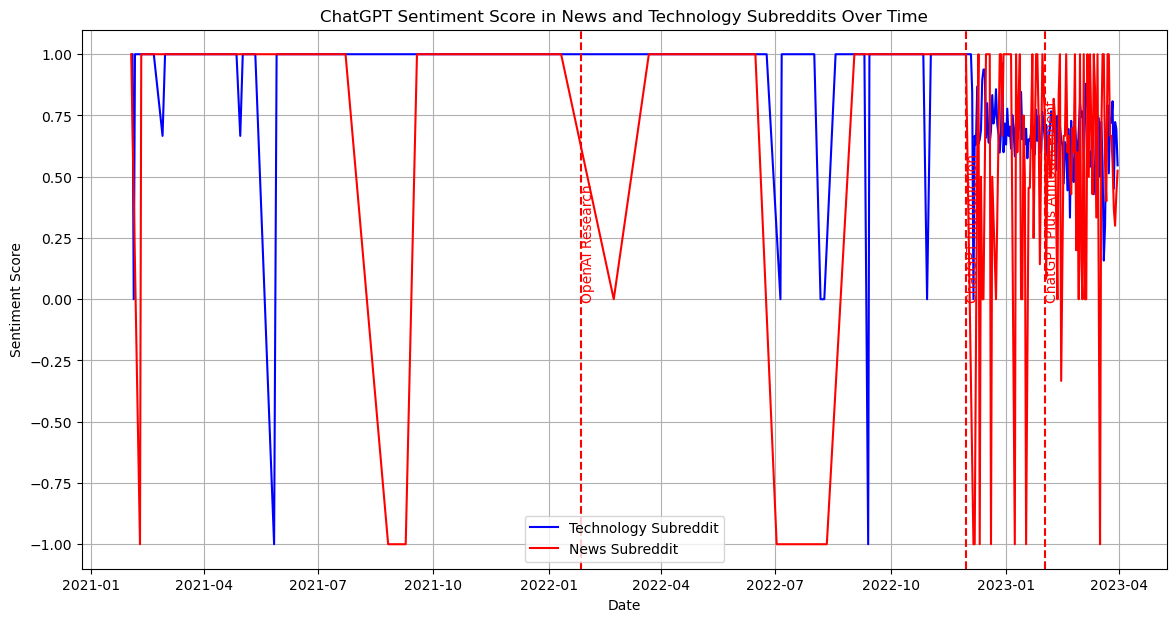

In [51]:
# Get the plot of sentiment score for chatgpt
contains_chatgpt_mean_sentiment=pd.read_csv("product_sentiment_score_com/contains_chatgpt_mean_sentiment.csv")
contains_chatgpt_mean_sentiment1=pd.read_csv("news_sentiment_score_com/contains_chatgpt_mean_sentiment.csv")

contains_chatgpt_mean_sentiment['created_date']=pd.to_datetime(contains_chatgpt_mean_sentiment['created_date'])
contains_chatgpt_mean_sentiment1['created_date']=pd.to_datetime(contains_chatgpt_mean_sentiment1['created_date'])
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(contains_chatgpt_mean_sentiment['created_date'], contains_chatgpt_mean_sentiment['chatgpt_mean_sentiment_score'], label='Technology Subreddit', color='blue')
plt.plot(contains_chatgpt_mean_sentiment1['created_date'], contains_chatgpt_mean_sentiment1['chatgpt_mean_sentiment_score'], label='News Subreddit', color='red')
# Add vertical lines for significant events
plt.axvline(x=pd.to_datetime('2022-01-27'), color='red', linestyle='--')
plt.text(pd.to_datetime('2022-01-27'), 0, "OpenAI Research", color='red', rotation=90)

plt.axvline(x=pd.to_datetime('2022-11-30'), color='red', linestyle='--')
plt.text(pd.to_datetime('2022-11-30'), 0, "ChatGPT Introduction", color='red', rotation=90)

plt.axvline(x=pd.to_datetime('2023-02-01'), color='red', linestyle='--')
plt.text(pd.to_datetime('2023-02-01'), 0, "ChatGPT Plus Announcement", color='red', rotation=90)

plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('ChatGPT Sentiment Score in News and Technology Subreddits Over Time')
plt.legend()
plt.grid(True)
plt.show()

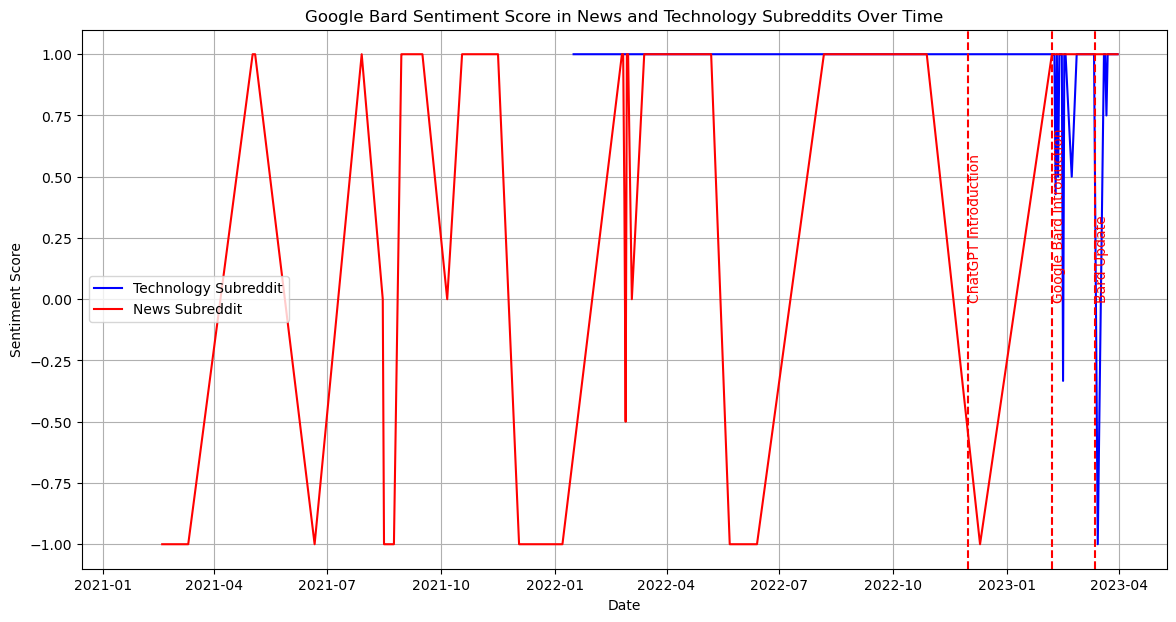

In [43]:
# Get the plot of sentiment score for bard
contains_bard_mean_sentiment=pd.read_csv("product_sentiment_score/contains_bard_mean_sentiment.csv")
contains_bard_mean_sentiment1=pd.read_csv("news_sentiment_score/contains_bard_mean_sentiment.csv")

contains_bard_mean_sentiment['created_date']=pd.to_datetime(contains_bard_mean_sentiment['created_date'])
contains_bard_mean_sentiment1['created_date']=pd.to_datetime(contains_bard_mean_sentiment1['created_date'])
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(contains_bard_mean_sentiment['created_date'], contains_bard_mean_sentiment['contains_bard_mean_sentiment'], label='Technology Subreddit', color='blue')
plt.plot(contains_bard_mean_sentiment1['created_date'], contains_bard_mean_sentiment1['contains_bard_mean_sentiment'], label='News Subreddit', color='red')
# Add vertical lines for significant events

plt.axvline(x=pd.to_datetime('2022-11-30'), color='red', linestyle='--')
plt.text(pd.to_datetime('2022-11-30'), 0, "ChatGPT Introduction", color='red', rotation=90)

plt.axvline(x=pd.to_datetime('2023-02-06'), color='red', linestyle='--')
plt.text(pd.to_datetime('2023-02-06'), 0, "Google Bard Introduction", color='red', rotation=90)

plt.axvline(x=pd.to_datetime('2023-03-13'), color='red', linestyle='--')
plt.text(pd.to_datetime('2023-03-13'), 0, "Bard Update", color='red', rotation=90)

plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Google Bard Sentiment Score in News and Technology Subreddits Over Time')
plt.legend()
plt.grid(True)
plt.show()

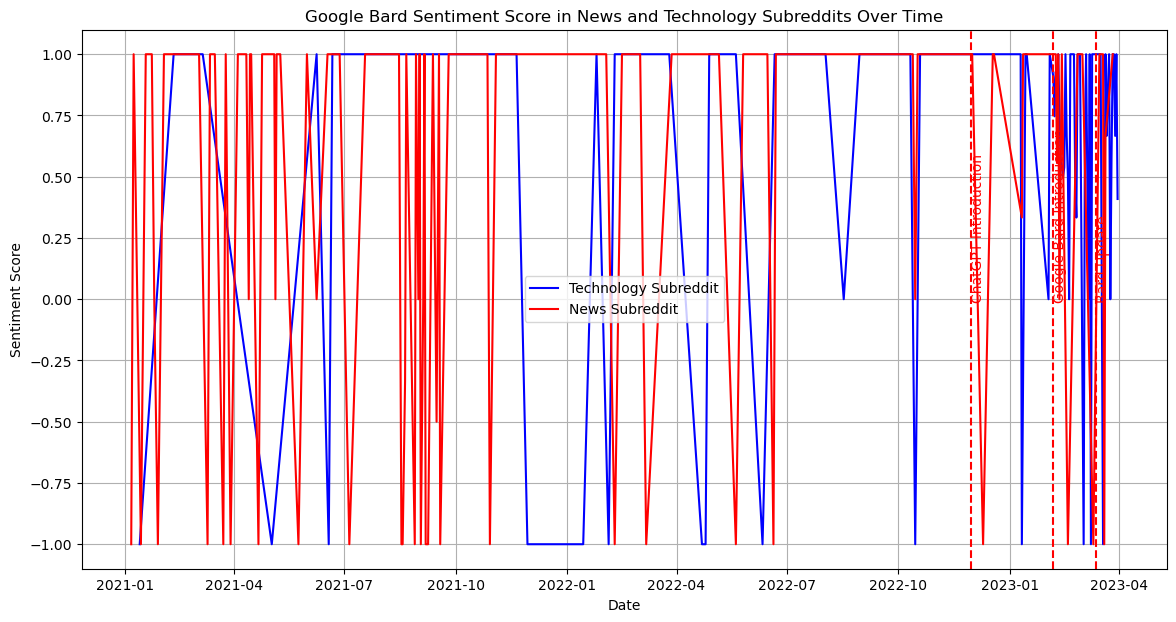

In [52]:
# Get the plot of sentiment score for bard
contains_bard_mean_sentiment=pd.read_csv("product_sentiment_score_com/contains_bard_mean_sentiment.csv")
contains_bard_mean_sentiment1=pd.read_csv("news_sentiment_score_com/contains_bard_mean_sentiment.csv")

contains_bard_mean_sentiment['created_date']=pd.to_datetime(contains_bard_mean_sentiment['created_date'])
contains_bard_mean_sentiment1['created_date']=pd.to_datetime(contains_bard_mean_sentiment1['created_date'])
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(contains_bard_mean_sentiment['created_date'], contains_bard_mean_sentiment['contains_bard_mean_sentiment'], label='Technology Subreddit', color='blue')
plt.plot(contains_bard_mean_sentiment1['created_date'], contains_bard_mean_sentiment1['contains_bard_mean_sentiment'], label='News Subreddit', color='red')
# Add vertical lines for significant events

plt.axvline(x=pd.to_datetime('2022-11-30'), color='red', linestyle='--')
plt.text(pd.to_datetime('2022-11-30'), 0, "ChatGPT Introduction", color='red', rotation=90)

plt.axvline(x=pd.to_datetime('2023-02-06'), color='red', linestyle='--')
plt.text(pd.to_datetime('2023-02-06'), 0, "Google Bard Introduction", color='red', rotation=90)

plt.axvline(x=pd.to_datetime('2023-03-13'), color='red', linestyle='--')
plt.text(pd.to_datetime('2023-03-13'), 0, "Bard Update", color='red', rotation=90)

plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Google Bard Sentiment Score in News and Technology Subreddits Over Time')
plt.legend()
plt.grid(True)
plt.show()

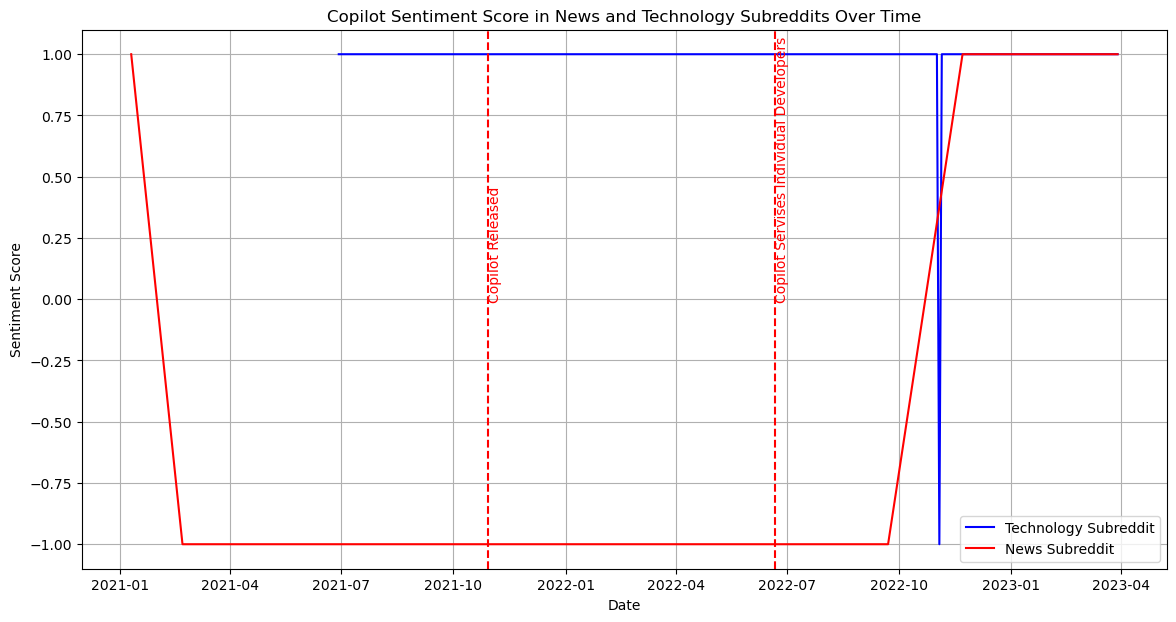

In [44]:
# Get the plot of sentiment score for copilot
contains_copilot_mean_sentiment=pd.read_csv("product_sentiment_score/contains_copilot_mean_sentiment.csv")
contains_copilot_mean_sentiment1=pd.read_csv("news_sentiment_score/contains_copilot_mean_sentiment.csv")

contains_copilot_mean_sentiment['created_date']=pd.to_datetime(contains_copilot_mean_sentiment['created_date'])
contains_copilot_mean_sentiment1['created_date']=pd.to_datetime(contains_copilot_mean_sentiment1['created_date'])
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(contains_copilot_mean_sentiment['created_date'], contains_copilot_mean_sentiment['contains_copilot_mean_sentiment'], label='Technology Subreddit', color='blue')
plt.plot(contains_copilot_mean_sentiment1['created_date'], contains_copilot_mean_sentiment1['contains_copilot_mean_sentiment'], label='News Subreddit', color='red')
# Add vertical lines for significant events

plt.axvline(x=pd.to_datetime('2021-10-29'), color='red', linestyle='--')
plt.text(pd.to_datetime('2021-10-29'), 0, "Copilot Released", color='red', rotation=90)

plt.axvline(x=pd.to_datetime('2022-06-21'), color='red', linestyle='--')
plt.text(pd.to_datetime('2022-06-21'), 0, "Copilot Servises Individual Developers", color='red', rotation=90)


plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Copilot Sentiment Score in News and Technology Subreddits Over Time')
plt.legend()
plt.grid(True)
plt.show()

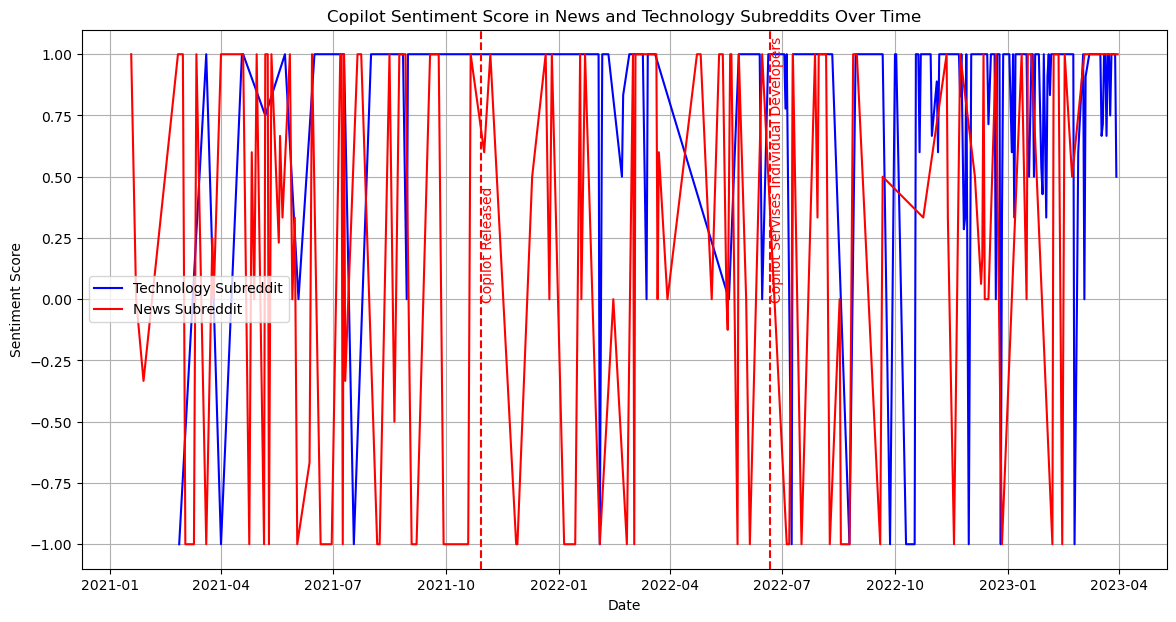

In [53]:
# Get the plot of sentiment score for copilot
contains_copilot_mean_sentiment=pd.read_csv("product_sentiment_score_com/contains_copilot_mean_sentiment.csv")
contains_copilot_mean_sentiment1=pd.read_csv("news_sentiment_score_com/contains_copilot_mean_sentiment.csv")

contains_copilot_mean_sentiment['created_date']=pd.to_datetime(contains_copilot_mean_sentiment['created_date'])
contains_copilot_mean_sentiment1['created_date']=pd.to_datetime(contains_copilot_mean_sentiment1['created_date'])
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(contains_copilot_mean_sentiment['created_date'], contains_copilot_mean_sentiment['contains_copilot_mean_sentiment'], label='Technology Subreddit', color='blue')
plt.plot(contains_copilot_mean_sentiment1['created_date'], contains_copilot_mean_sentiment1['contains_copilot_mean_sentiment'], label='News Subreddit', color='red')
# Add vertical lines for significant events

plt.axvline(x=pd.to_datetime('2021-10-29'), color='red', linestyle='--')
plt.text(pd.to_datetime('2021-10-29'), 0, "Copilot Released", color='red', rotation=90)

plt.axvline(x=pd.to_datetime('2022-06-21'), color='red', linestyle='--')
plt.text(pd.to_datetime('2022-06-21'), 0, "Copilot Servises Individual Developers", color='red', rotation=90)


plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Copilot Sentiment Score in News and Technology Subreddits Over Time')
plt.legend()
plt.grid(True)
plt.show()

#### Difference of mean sentiment score in submission and comment from r/technology and r/news

In [57]:
# List of product names
# We get 0 sample of sentiment score for: apple, dog, and humanoid
products = [
    'chatgpt', 'aurora', 'bard', 'copilot', 
    'deepmind', 'drone', 'metaverse', 'mobileye', 'roomba',
    'oculus', 'waymo'
]

# Initialize an empty DataFrame to hold the combined data
combined_df = pd.DataFrame()

for product in products:
    # Read the CSV into a DataFrame
    temp_df = pd.read_csv(f"news_sentiment_score_com/contains_{product}_mean_sentiment.csv")
    
    # Make sure the 'created_date' column is datetime type for merging and plotting
    temp_df['created_date'] = pd.to_datetime(temp_df['created_date'])
    
    # Rename the sentiment column to the product's name for clarity after merge
    temp_df.rename(columns={temp_df.columns[1]: f"{product}_sentiment"}, inplace=True)
    
    if combined_df.empty:
        combined_df = temp_df
    else:
        # Merge the temporary DataFrame into the combined DataFrame on the 'created_date' column
        combined_df = pd.merge(combined_df, temp_df, on='created_date', how='outer')

# Ensure the combined DataFrame is sorted by date
combined_df.sort_values('created_date', inplace=True)

# Calculate the average sentiment score for every product
average_sentiments = combined_df.mean(axis=0, skipna=True)[1:]
sorted_average_sentiments = average_sentiments.sort_values(ascending=False).reset_index()
sorted_average_sentiments = sorted_average_sentiments.rename(columns={0:'news_com'})
sorted_average_sentiments

,index,news_com
0,mobileye_sentiment,1.0
1,metaverse_sentiment,0.744444
2,waymo_sentiment,0.673131
3,deepmind_sentiment,0.666667
4,bard_sentiment,0.58642
5,chatgpt_sentiment,0.517576
6,roomba_sentiment,0.42621
7,oculus_sentiment,0.367466
8,copilot_sentiment,0.203449
9,drone_sentiment,-0.045901


In [58]:
# Initialize an empty DataFrame to hold the combined data
combined_df = pd.DataFrame()

for product in products:
    # Read the CSV into a DataFrame
    temp_df = pd.read_csv(f"news_sentiment_score/contains_{product}_mean_sentiment.csv")
    
    # Make sure the 'created_date' column is datetime type for merging and plotting
    temp_df['created_date'] = pd.to_datetime(temp_df['created_date'])
    
    # Rename the sentiment column to the product's name for clarity after merge
    temp_df.rename(columns={temp_df.columns[1]: f"{product}_sentiment"}, inplace=True)
    
    if combined_df.empty:
        combined_df = temp_df
    else:
        # Merge the temporary DataFrame into the combined DataFrame on the 'created_date' column
        combined_df = pd.merge(combined_df, temp_df, on='created_date', how='outer')

# Ensure the combined DataFrame is sorted by date
combined_df.sort_values('created_date', inplace=True)

# Calculate the average sentiment score for every product
average_sentiments = combined_df.mean(axis=0, skipna=True)[1:]
sorted_average_sentiments1 = average_sentiments.sort_values(ascending=False).reset_index()
sorted_average_sentiments1 = sorted_average_sentiments1.rename(columns={0:'news_sub'})
sorted_average_sentiments1

,index,news_sub
0,mobileye_sentiment,1.0
1,roomba_sentiment,0.888889
2,metaverse_sentiment,0.808156
3,deepmind_sentiment,0.777778
4,oculus_sentiment,0.722222
5,chatgpt_sentiment,0.568367
6,bard_sentiment,0.450943
7,waymo_sentiment,0.153846
8,aurora_sentiment,0.088235
9,copilot_sentiment,-0.090909


In [59]:
# Initialize an empty DataFrame to hold the combined data
combined_df = pd.DataFrame()

for product in products:
    # Read the CSV into a DataFrame
    temp_df = pd.read_csv(f"product_sentiment_score/contains_{product}_mean_sentiment.csv")
    
    # Make sure the 'created_date' column is datetime type for merging and plotting
    temp_df['created_date'] = pd.to_datetime(temp_df['created_date'])
    
    # Rename the sentiment column to the product's name for clarity after merge
    temp_df.rename(columns={temp_df.columns[1]: f"{product}_sentiment"}, inplace=True)
    
    if combined_df.empty:
        combined_df = temp_df
    else:
        # Merge the temporary DataFrame into the combined DataFrame on the 'created_date' column
        combined_df = pd.merge(combined_df, temp_df, on='created_date', how='outer')

# Ensure the combined DataFrame is sorted by date
combined_df.sort_values('created_date', inplace=True)

# Calculate the average sentiment score for every product
average_sentiments = combined_df.mean(axis=0, skipna=True)[1:]
sorted_average_sentiments2 = average_sentiments.sort_values(ascending=False).reset_index()
sorted_average_sentiments2 = sorted_average_sentiments2.rename(columns={0:'tech_sub'})
sorted_average_sentiments2

,index,tech_sub
0,copilot_sentiment,0.945946
1,mobileye_sentiment,0.916667
2,bard_sentiment,0.833717
3,metaverse_sentiment,0.796199
4,deepmind_sentiment,0.658537
5,oculus_sentiment,0.650538
6,chatgpt_sentiment,0.596356
7,waymo_sentiment,0.5
8,roomba_sentiment,0.478261
9,drone_sentiment,0.279767


In [60]:
# Initialize an empty DataFrame to hold the combined data
combined_df = pd.DataFrame()

for product in products:
    # Read the CSV into a DataFrame
    temp_df = pd.read_csv(f"product_sentiment_score_com/contains_{product}_mean_sentiment.csv")
    
    # Make sure the 'created_date' column is datetime type for merging and plotting
    temp_df['created_date'] = pd.to_datetime(temp_df['created_date'])
    
    # Rename the sentiment column to the product's name for clarity after merge
    temp_df.rename(columns={temp_df.columns[1]: f"{product}_sentiment"}, inplace=True)
    
    if combined_df.empty:
        combined_df = temp_df
    else:
        # Merge the temporary DataFrame into the combined DataFrame on the 'created_date' column
        combined_df = pd.merge(combined_df, temp_df, on='created_date', how='outer')

# Ensure the combined DataFrame is sorted by date
combined_df.sort_values('created_date', inplace=True)

# Calculate the average sentiment score for every product
average_sentiments = combined_df.mean(axis=0, skipna=True)[1:]
sorted_average_sentiments3 = average_sentiments.sort_values(ascending=False).reset_index()
sorted_average_sentiments3 = sorted_average_sentiments3.rename(columns={0:'tech_com'})
sorted_average_sentiments3

,index,tech_com
0,deepmind_sentiment,0.883584
1,metaverse_sentiment,0.797708
2,chatgpt_sentiment,0.783931
3,copilot_sentiment,0.779096
4,mobileye_sentiment,0.730612
5,waymo_sentiment,0.705428
6,bard_sentiment,0.577721
7,roomba_sentiment,0.539742
8,oculus_sentiment,0.485302
9,aurora_sentiment,0.423077


In [62]:
df1 = pd.merge(sorted_average_sentiments, sorted_average_sentiments1, on ='index',how='inner')
df2 = pd.merge(df1, sorted_average_sentiments2, on ='index',how='inner')
df = pd.merge(df2, sorted_average_sentiments3, on ='index',how='inner')
df

,index,news_com,news_sub,tech_sub,tech_com
0,mobileye_sentiment,1.0,1.0,0.916667,0.730612
1,metaverse_sentiment,0.744444,0.808156,0.796199,0.797708
2,waymo_sentiment,0.673131,0.153846,0.5,0.705428
3,deepmind_sentiment,0.666667,0.777778,0.658537,0.883584
4,bard_sentiment,0.58642,0.450943,0.833717,0.577721
5,chatgpt_sentiment,0.517576,0.568367,0.596356,0.783931
6,roomba_sentiment,0.42621,0.888889,0.478261,0.539742
7,oculus_sentiment,0.367466,0.722222,0.650538,0.485302
8,copilot_sentiment,0.203449,-0.090909,0.945946,0.779096
9,drone_sentiment,-0.045901,-0.201471,0.279767,0.327782


In [63]:
df.to_csv('mean_sentiment.csv',index=False)

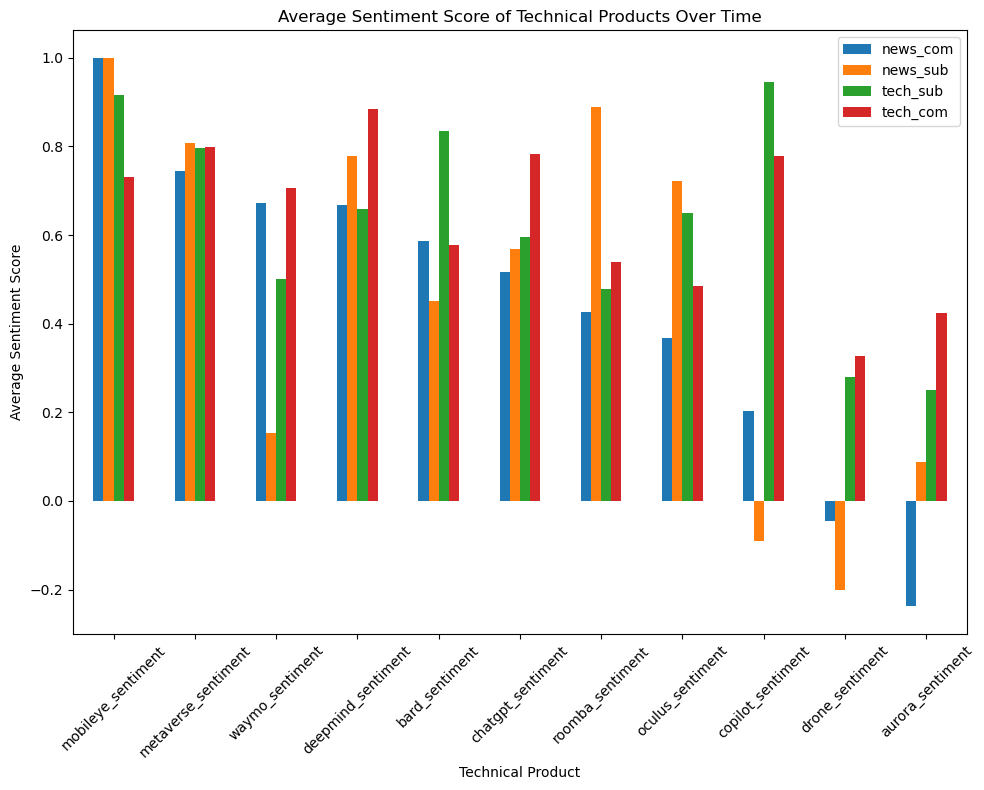

In [65]:
# Create a bar plot 
df.plot(kind='bar',x='index', figsize=(10, 8))

plt.title('Average Sentiment Score of Technical Products Over Time')
plt.xlabel('Technical Product')
plt.ylabel('Average Sentiment Score')

plt.xticks(rotation=45)
plt.tight_layout()  

plt.show()